# Setting

## Library

In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import random
import os
from tqdm.notebook import tqdm

In [4]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

In [5]:
from sklearn.decomposition import PCA, SparsePCA, KernelPCA
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.decomposition import MiniBatchDictionaryLearning, FastICA

In [37]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score # 정확도
from sklearn.metrics import precision_score # 정밀도
from sklearn.metrics import recall_score # 재현율
from sklearn.metrics import f1_score # F1-Score
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import manhattan_distances

In [7]:
import warnings
warnings.filterwarnings('ignore')

## Seed

In [8]:
def my_seed_everywhere(seed):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    print(f'고정된 Seed : {seed}')

In [9]:
my_seed_everywhere(42)

고정된 Seed : 42


# Data Set

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
path_file = '/content/drive/MyDrive/UNIST/AICP/data/dynmom_dat.csv'

df = pd.read_csv(path_file)

# Preprocessing

In [12]:
def preprocessing(data, used=None):
  # 'DATE'를 칼럼 대신 인덱스로 사용
  data.index = data['DATE']
  data = data.drop(columns='DATE')
  print("'DATE'를 칼럼 대신 인덱스로 사용")

  # 결측치 제거 및 모델 학습에 불필요한 칼럼 제거
  data = data.dropna()
  data = data.drop(columns=['winner', 'loser', 'form_date'])
  print("결측치 제거 및 모델 학습에 불필요한 칼럼 제거 ('winner', 'loser', 'form_date')")

  if used != None:
    used += ['wml']
    D = ', '.join(used)
    data = data[used]
    print(f"훈련에 사용되는 변수 들 : {D}")

  return data

In [13]:
dynmom = preprocessing(df,
                       used=['mvol_t_1', 'mvol_t_2', 'mvol_t_3', 'mvol_t_4' , 'mvol_t_5', 'mvol_t_6',
                             'cum_winner_t_2_4', 'cum_winner_t_5_8', 'cum_winner_t_9_12',
                             'cum_loser_t_2_4', 'cum_loser_t_5_8', 'cum_loser_t_9_12'])

'DATE'를 칼럼 대신 인덱스로 사용
결측치 제거 및 모델 학습에 불필요한 칼럼 제거 ('winner', 'loser', 'form_date')
훈련에 사용되는 변수 들 : mvol_t_1, mvol_t_2, mvol_t_3, mvol_t_4, mvol_t_5, mvol_t_6, cum_winner_t_2_4, cum_winner_t_5_8, cum_winner_t_9_12, cum_loser_t_2_4, cum_loser_t_5_8, cum_loser_t_9_12, wml


# Modeling

In [14]:
def define_pos_wml(df, purpose):

  if purpose == 'train':
    cond_wml = (df['wml']>=0.0)
    df.loc[cond_wml, 'pos_wml'] = 0
    df.loc[~cond_wml, 'pos_wml'] = 1

  if purpose == 'test':
    cond_wml = (df['wml']>=0.0)
    df.loc[cond_wml, 'pos_wml'] = 0
    df.loc[~cond_wml, 'pos_wml'] = 1


  return df

In [130]:
def sigmoid(x):
  score = 1/(1 +np.exp(-x))
  return score

In [131]:
def Roling_Windows(data, window_size, method, model, thr):

  # 학습 및 테스트 데이터 정보 & 실제값과 예측값 정보 수집
  result_dict = {
      'TRAIN_START_DATE':[], # 훈련 데이터 시작 지점
      'TRAIN_END_DATE':[], # 훈련 데이터 마지막 지점
      'TEST_DATE':[], # 테스트 데이터 지점
      'wml':[], # wml 값
      'dynamic_momentum':[], # 다이나믹 모멘텀 값
      'dynamic_leverage':[], # 추론된 Target 확률값
      'anomaly_score':[],
      'Actual_POS_WML':[], # 실제 Target 값 (0 or 1)
      'static_leverage':[], # 추론된 Target 값 (0 or 1)
                }

  df_feature = pd.DataFrame()

  # 모델 학습이 종료되는 지점 설정
  end = data.shape[0] - window_size

  for i in tqdm(range(end)):

    # 모델 학습 중지
    if i == end:
      print('Prediction using machine learning has ended.')
      break

    # Rolling Fixed Window
    if method == 'Fixed':
      MODEL = model
      train = data.iloc[0+i:window_size+i]
      TRAIN = define_pos_wml(train, purpose='train')
      TRAIN = TRAIN.loc[TRAIN['pos_wml']==0] # 비지도 학습 : 주석 처리하고 모델 학습 시 label 입력하지 않을 것

    # Rolling Expanding Window
    elif method == 'Expanding':
      MODEL = model
      train = data.iloc[0:window_size+i]
      TRAIN = define_pos_wml(train, purpose='train')
      TRAIN = TRAIN.loc[TRAIN['pos_wml']==0] # 비지도 학습 : 주석 처리하고 모델 학습 시 label 입력하지 않을 것

    # 테스트 데이터 설정
    test = data.iloc[[window_size+i]]
    TEST = define_pos_wml(test, purpose='test')

    # Features와 Target 구분
    X_train = TRAIN.drop(columns=['pos_wml', 'wml'])
    y_train = TRAIN['pos_wml']

    X_test = TEST.drop(columns=['pos_wml', 'wml'])
    y_test = TEST['pos_wml']

    wml_test = list(test['wml'])

    # 모델 학습 및 추론
    MODEL.fit(X_train)

    #MODEL.fit(X_train) # 비지도 학습 시 사용
    X_test_PCA = MODEL.transform(X_test)
    X_test_PCA = pd.DataFrame(data=X_test_PCA, index=X_test.index)

    X_test_PCA_inverse = MODEL.inverse_transform(X_test_PCA)
    X_test_PCA_inverse = pd.DataFrame(data=X_test_PCA_inverse,
                                      index=X_test.index)

    prob_test = cosine_similarity(X_test, X_test_PCA_inverse)
    prob_test = prob_test[0][0]

    if prob_test >= thr:
      pred_test = 0
    else:
      pred_test = 1

    # 학습 및 테스트 데이터 정보 & 실제값과 예측값 정보 수집
    result_dict['TRAIN_START_DATE'].append(train.index[0])
    result_dict['TRAIN_END_DATE'].append(train.index[-1])
    result_dict['TEST_DATE'].append(str(test.index[0]))

    result_dict['wml'].append(wml_test[0])

    dynamic_momentum = prob_test * wml_test[0]
    result_dict['dynamic_momentum'].append(dynamic_momentum)

    result_dict['Actual_POS_WML'].append(int(list(y_test)[0]))
    result_dict['static_leverage'].append(pred_test)
    result_dict['dynamic_leverage'].append(sigmoid(prob_test))
    result_dict['anomaly_score'].append(prob_test)

  result = pd.DataFrame(result_dict)
  result = result.set_index('TEST_DATE')

  # 학습 및 테스트 데이터 정보, 실제값과 예측값 정보, 변수 중요도 정보
  return result

# Inference

In [132]:
def cum_return_sharpe_ratio(data, dynamic=True):

  if dynamic == True:
    weight = 'dynamic_leverage'
  else:
    weight = 'static_leverage'

  # 머신러닝 적용되지 않은 경우 Sharpe Ratio
  w_S = (data['wml'].mean()/data['wml'].std()) * math.sqrt(12)
  print('ORG Sharpe Ratio : {}'.format(w_S))

  # 머신러닝 적용된 경우 Sharpe Ratio
  S = (data['dynamic_momentum'].mean()/data['dynamic_momentum'].std())*math.sqrt(12)
  print('ML Sharpe Ratio : {}\n'.format(S))

  # 머신러닝 적용된 경우 누적 수익률
  data['cum_return'] = (1 + data.dynamic_momentum).cumprod() - 1

  print('\n최근 누적 수익률\n')
  latly_10 = data[['cum_return']].sort_index(ascending=False).head(5)
  for i, r in zip(latly_10.index, latly_10['cum_return']):
    i = str(i)
    print('  {}년-{}월 -> {:0.2f}'.format(i[:4], i[4:6], r))

  print('\n누적 수익률 가장 높았던 순간 Top 10\n')
  top_10 = data[['cum_return']].sort_values(by='cum_return', ascending=False).head(10)
  rank = 1
  for i, r in zip(top_10.index, top_10['cum_return']):
    i = str(i)
    print('  {}등 : {}년-{}월 -> {:0.2f}'.format(rank, i[:4], i[4:6], r))
    rank += 1
  print()

  # 머신러닝 적용되지 않은 경우 누적 수익률
  without_machine = pd.DataFrame(data['wml'])
  without_machine['wml'] = (1 + without_machine.wml).cumprod() - 1
  without_machine.columns = ['cum_return']

  # 머신러닝 여부에 따른 누적 수익률 비교
  plt.figure(figsize=(13, 6))
  plt.title('Comparing Cumulative Returns with and without Machine Learning')
  sns.lineplot(data=data, x=data.index, y=data['cum_return'], label='With_ML', color='darkgreen', lw=3)
  sns.lineplot(data=without_machine, x=without_machine.index, y=without_machine['cum_return'], label='Original', color='gray', lw=3)
  plt.xticks([data.index[i] for i in range(0,len(data.index), 12)])
  plt.tick_params(axis='x',
                  direction='out',
                  labelrotation=45,
                  length=1,
                  pad=10,
                  labelsize=5,
                  width=5)

  plt.show()

In [133]:
def statistic_information(data, col):
  statistic = data[[col]].describe().T
  statistic['var'] = data[col].var()
  statistic['1%'] = data[col].quantile(0.01)
  statistic['99%'] = data[col].quantile(0.99)

  statistic = statistic[['count', 'mean', 'var', 'std',
                         'min', '1%', '25%', '50%',
                         '75%',  '99%', 'max']]

  return statistic

In [134]:
def plot_predict_result(data):
  print('\nPerformance results of the model\n')

  # Confusion Matrix & etc
  print(classification_report(data['Actual_POS_WML'], data['static_leverage']))

  # Accuracy, Precision, Recall, F1 Score
  accuracy = accuracy_score(data['Actual_POS_WML'], data['static_leverage'])
  precision = precision_score(data['Actual_POS_WML'], data['static_leverage'])
  recall = recall_score(data['Actual_POS_WML'], data['static_leverage'])
  F1_score = f1_score(data['Actual_POS_WML'], data['static_leverage'])

  print(f'\naccuracy : {accuracy}')
  print(f'\nprecision : {precision}')
  print(f'\nrecall : {recall}')
  print(f'\nF1-Score : {F1_score}\n')

  # Visualization Confusion Matrix
  confusion = confusion_matrix(data['Actual_POS_WML'], data['static_leverage'])
  sns.heatmap(confusion, annot=True, fmt='g')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.title(f'Confusion Matrix')

  plt.show()

  # ACTUAL = PRED = 1
  cond = (data['Actual_POS_WML'] == 1) & (data['static_leverage'] == 1)
  cond_data = data.loc[cond]
  print('\nACTUAL = PRED = 1\n')
  plt.figure(figsize=(15, 5))
  plt.title('WML & Dynamic Leverage in ACTUAL = PRED = 1')
  sns.lineplot(data=cond_data,
              x=cond_data.index,
              y='wml',
              label='wml')
  sns.lineplot(data=cond_data,
              x=cond_data.index,
              y='dynamic_leverage',
              label='dynamic_leverage')
  plt.xticks([cond_data.index[i] for i in range(0,len(cond_data.index), 12)])
  plt.tick_params(axis='x',
                  direction='out',
                  labelrotation=45,
                  length=1,
                  pad=10,
                  labelsize=5,
                  width=5)
  plt.show()
  info = statistic_information(cond_data, 'wml')
  display(info)
  info = statistic_information(cond_data, 'dynamic_leverage')
  display(info)

  print()
  print('-'*80)
  print()

  # ACTUAL = PRED = 0
  cond = (data['Actual_POS_WML'] == 0) & (data['static_leverage'] == 0)
  cond_data = data.loc[cond]
  print('\nACTUAL = PRED = 0\n')
  plt.figure(figsize=(15, 5))
  plt.title('WML & Dynamic Leverage in ACTUAL = PRED = 0')
  sns.lineplot(data=cond_data,
              x=cond_data.index,
              y='wml',
              label='wml')
  sns.lineplot(data=cond_data,
              x=cond_data.index,
              y='dynamic_leverage',
              label='dynamic_leverage')
  plt.xticks([cond_data.index[i] for i in range(0,len(cond_data.index), 12)])
  plt.tick_params(axis='x',
                  direction='out',
                  labelrotation=45,
                  length=1,
                  pad=10,
                  labelsize=5,
                  width=5)
  plt.show()
  info = statistic_information(cond_data, 'wml')
  display(info)
  info = statistic_information(cond_data, 'dynamic_leverage')
  display(info)

  print()
  print('-'*80)
  print()

  # ACTUAL = 0 & PRED = 1
  cond = (data['Actual_POS_WML'] == 0) & (data['static_leverage'] == 1)
  cond_data = data.loc[cond]
  print('\nACTUAL = 0 &  PRED = 1\n')
  plt.figure(figsize=(15, 5))
  plt.title('WML & Dynamic Leverage in ACTUAL = 0 & PRED = 1')
  sns.lineplot(data=cond_data,
              x=cond_data.index,
              y='wml',
              label='wml')
  sns.lineplot(data=cond_data,
              x=cond_data.index,
              y='dynamic_leverage',
              label='dynamic_leverage')
  plt.xticks([cond_data.index[i] for i in range(0,len(cond_data.index), 12)])
  plt.tick_params(axis='x',
                  direction='out',
                  labelrotation=45,
                  length=1,
                  pad=10,
                  labelsize=5,
                  width=5)
  plt.show()
  info = statistic_information(cond_data, 'wml')
  display(info)
  info = statistic_information(cond_data, 'dynamic_leverage')
  display(info)

  print()
  print('-'*80)
  print()

  # ACTUAL = 1 & PRED = 0
  cond = (data['Actual_POS_WML'] == 1) & (data['static_leverage'] == 0)
  cond_data = data.loc[cond]
  print('\nACTUAL = 1 &  PRED = 0\n')
  plt.figure(figsize=(15, 5))
  plt.title('WML & Dynamic Leverage in ACTUAL = 1 & PRED = 0')
  sns.lineplot(data=cond_data,
              x=cond_data.index,
              y='wml',
              label='wml')
  sns.lineplot(data=cond_data,
              x=cond_data.index,
              y='dynamic_leverage',
              label='dynamic_leverage')
  plt.xticks([cond_data.index[i] for i in range(0,len(cond_data.index), 12)])
  plt.tick_params(axis='x',
                  direction='out',
                  labelrotation=45,
                  length=1,
                  pad=10,
                  labelsize=5,
                  width=5)
  plt.show()
  info = statistic_information(cond_data, 'wml')
  display(info)
  info = statistic_information(cond_data, 'dynamic_leverage')
  display(info)

In [135]:
def plot_dynamic_momentum(data):

  print('\nTop 5 dyn_mom\n')
  display(data.sort_values(by='dynamic_momentum', ascending=False).head(5))

  print('\nBottom 5 dyn_mom\n')
  display(data.sort_values(by='dynamic_momentum', ascending=True).head(5))
  print()

  plt.figure(figsize=(13,8))
  plt.title('Histogram of Dynamic Momentum')
  sns.histplot(data=data, x='dynamic_momentum', kde=True)
  plt.show()
  print()

  info = statistic_information(data, 'dynamic_momentum')
  display(info)
  print()

  plt.figure(figsize=(13,8))
  plt.title('Histogram of Dynamic Leverage')
  sns.histplot(data=data, x='dynamic_leverage', kde=True)
  plt.show()
  print()

  info = statistic_information(data, 'dynamic_leverage')
  display(info)
  print()

  plt.figure(figsize=(13,8))
  plt.title('Histogram of Anomaly Score')
  sns.histplot(data=data, x='anomaly_score', kde=True)
  plt.show()
  print()

  info = statistic_information(data, 'anomaly_score')
  display(info)
  print()

  plt.figure(figsize=(15, 5))
  plt.title('Line Plot of Dynamic Momentum')
  sns.lineplot(data=data, x=data.index, y='dynamic_momentum', marker='o', markersize=0.5 ,linewidth=2)
  plt.xticks([data.index[i] for i in range(0, len(data.index), 36)],
             labels=[data.index[i][:4] for i in range(0, len(data.index), 36)])
  plt.tick_params(axis='x',
                  direction='out',
                  labelrotation=45,
                  length=1,
                  pad=10,
                  labelsize=13,
                  width=5)
  plt.show()
  print()

  plt.figure(figsize=(15, 5))
  plt.title('Dynamic Leverage vs. WML')
  sns.lineplot(data=data, x=data.index, y='wml', label='WML',linewidth=0.5, color='orange')
  sns.lineplot(data=data, x=data.index, y='dynamic_leverage', label='Dynamic Leverage' ,linewidth=0.5, color='green')

  plt.xticks([data.index[i] for i in range(0, len(data.index), 36)],
             labels=[data.index[i][:4] for i in range(0, len(data.index), 36)])
  plt.tick_params(axis='x',
                  direction='out',
                  labelrotation=45,
                  length=1,
                  pad=10,
                  labelsize=10,
                  width=5)
  plt.legend()
  plt.show()

## PCA

In [136]:
PCA_Param={'n_components':1,
           'whiten':True,
           'random_state':42}
PCA_MODEL = PCA(**PCA_Param)

In [137]:
Fixed_PCA_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=PCA_MODEL,
                                  thr=0.50)

  0%|          | 0/906 [00:00<?, ?it/s]

In [138]:
Fixed_PCA_Result.head(10)

TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
19470731           19270730        19470630 -0.052114         -0.019848   
19470829           19270831        19470731  0.030634          0.012903   
19470930           19270930        19470829 -0.038537         -0.020630   
19471031           19271031        19470930  0.044931          0.037878   
19471129           19271130        19471031  0.053920          0.048016   
19471231           19271231        19471129  0.057494          0.055229   
19480131           19280131        19471231 -0.045630         -0.039666   
19480228           19280229        19480131  0.044267          0.034214   
19480331           19280331        19480228 -0.018584         -0.015796   
19480430           19280430        19480331  0.067995          0.054496   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  
TEST_DATE                                                                    
19470731           0.594081       0.380860               1                1  
19470829           0.603768       0.421191               0                1  
19470930           0.630726       0.535331               1                0  
19471031           0.699102       0.843025               0                0  
19471129           0.708993       0.890499               0                0  
19471231           0.723242       0.960600               0                0  
19480131           0.704598       0.869289               1                0  
19480228           0.684150       0.772908               0                0  
19480331           0.700553       0.849931               1                0  
19480430           0.690291       0.801480               0                0

In [139]:
Fixed_PCA_Result.loc[Fixed_PCA_Result['static_leverage']==0]

TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
19470930           19270930        19470829 -0.038537         -0.020630   
19471031           19271031        19470930  0.044931          0.037878   
19471129           19271130        19471031  0.053920          0.048016   
19471231           19271231        19471129  0.057494          0.055229   
19480131           19280131        19471231 -0.045630         -0.039666   
...                     ...             ...       ...               ...   
20220831           20020830        20220729 -0.021856         -0.019317   
20220930           20020930        20220831  0.099930          0.091980   
20221031           20021031        20220930  0.129322          0.118746   
20221130           20021129        20221031  0.051291          0.045704   
20221230           20021231        20221130  0.109899          0.098499   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  
TEST_DATE                                                                    
19470930           0.630726       0.535331               1                0  
19471031           0.699102       0.843025               0                0  
19471129           0.708993       0.890499               0                0  
19471231           0.723242       0.960600               0                0  
19480131           0.704598       0.869289               1                0  
...                     ...            ...             ...              ...  
20220831           0.707618       0.883843               1                0  
20220930           0.715133       0.920447               0                0  
20221031           0.714680       0.918225               0                0  
20221130           0.709110       0.891067               0                0  
20221230           0.710181       0.896265               0                0  

[902 rows x 8 columns]

In [140]:
Fixed_PCA_Result.loc[Fixed_PCA_Result['static_leverage']==1]

TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
19470731           19270730        19470630 -0.052114         -0.019848   
19470829           19270831        19470731  0.030634          0.012903   
20090731           19890731        20090630 -0.070753         -0.014683   
20091130           19891130        20091030  0.047411          0.020180   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  
TEST_DATE                                                                    
19470731           0.594081       0.380860               1                1  
19470829           0.603768       0.421191               0                1  
20090731           0.551695       0.207523               1                1  
20091130           0.604834       0.425646               0                1

ORG Sharpe Ratio : 0.7293406994683723
ML Sharpe Ratio : 0.7645507729006024


최근 누적 수익률

  2022년-12월 -> 82553.31
  2022년-11월 -> 75150.92
  2022년-10월 -> 71866.29
  2022년-09월 -> 64238.13
  2022년-08월 -> 58827.11

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 82553.31
  2등 : 2009년-02월 -> 78015.88
  3등 : 2002년-09월 -> 76684.37
  4등 : 2022년-11월 -> 75150.92
  5등 : 2022년-10월 -> 71866.29
  6등 : 2009년-01월 -> 71211.84
  7등 : 2008년-11월 -> 71049.92
  8등 : 2008년-12월 -> 69684.98
  9등 : 2002년-07월 -> 68401.46
  10등 : 2002년-08월 -> 66554.39



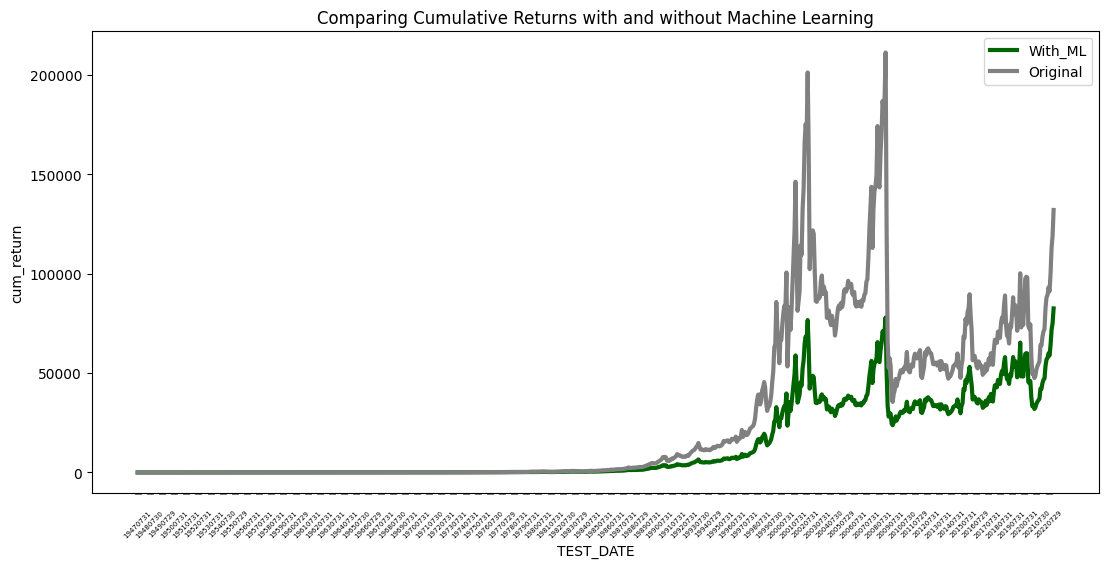

In [141]:
cum_return_sharpe_ratio(data=Fixed_PCA_Result,
                        dynamic=True)


Performance results of the model

              precision    recall  f1-score   support

           0       0.65      1.00      0.79       590
           1       0.50      0.01      0.01       316

    accuracy                           0.65       906
   macro avg       0.58      0.50      0.40       906
weighted avg       0.60      0.65      0.52       906


accuracy : 0.6512141280353201

precision : 0.5

recall : 0.006329113924050633

F1-Score : 0.012499999999999999



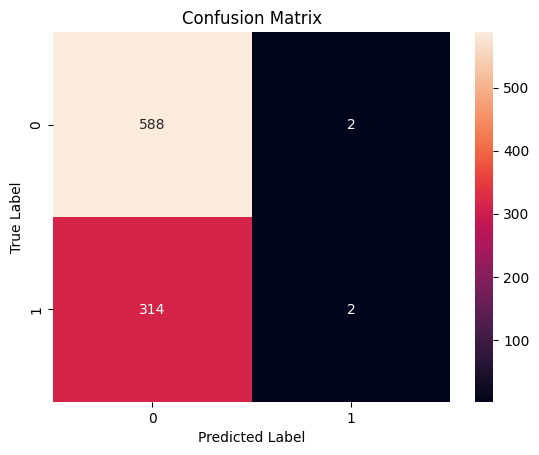


ACTUAL = PRED = 1



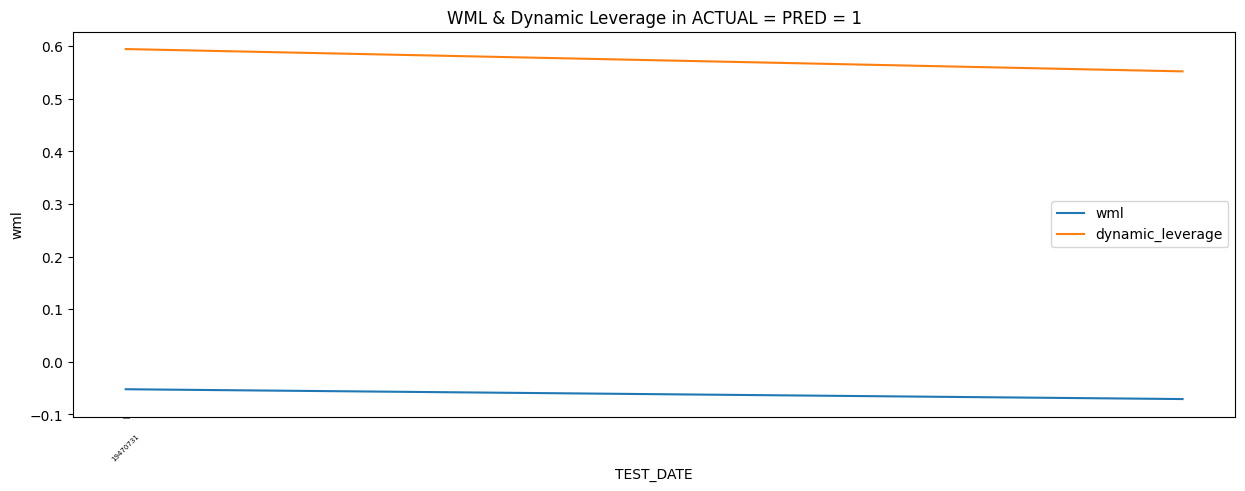

count      mean       var       std       min        1%       25%  \
wml    2.0 -0.061433  0.000174  0.013179 -0.070753 -0.070566 -0.066093   

          50%       75%       99%       max  
wml -0.061433 -0.056774 -0.052301 -0.052114

count      mean       var       std       min        1%  \
dynamic_leverage    2.0  0.572888  0.000898  0.029971  0.551695  0.552119   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.562292  0.572888  0.583484  0.593657  0.594081


--------------------------------------------------------------------------------


ACTUAL = PRED = 0



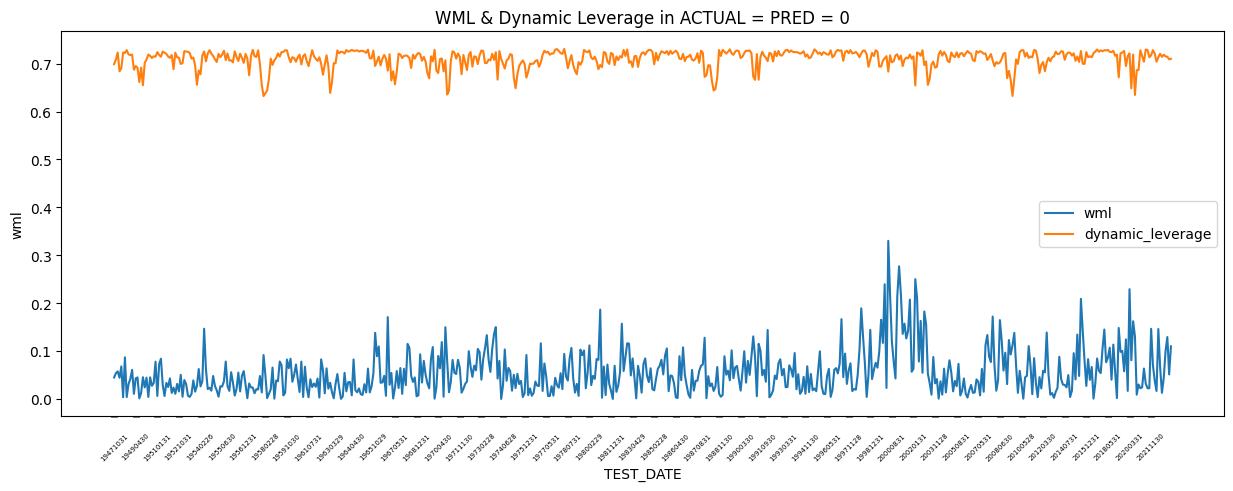

count      mean       var       std       min        1%       25%  \
wml  588.0  0.055305  0.002198  0.046879  0.000007  0.000687  0.021416   

         50%       75%      99%       max  
wml  0.04509  0.077301  0.21716  0.330163

count      mean       var       std      min        1%  \
dynamic_leverage  588.0  0.710474  0.000339  0.018408  0.63234  0.642864   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.704537  0.715532  0.723164  0.729655  0.730736


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



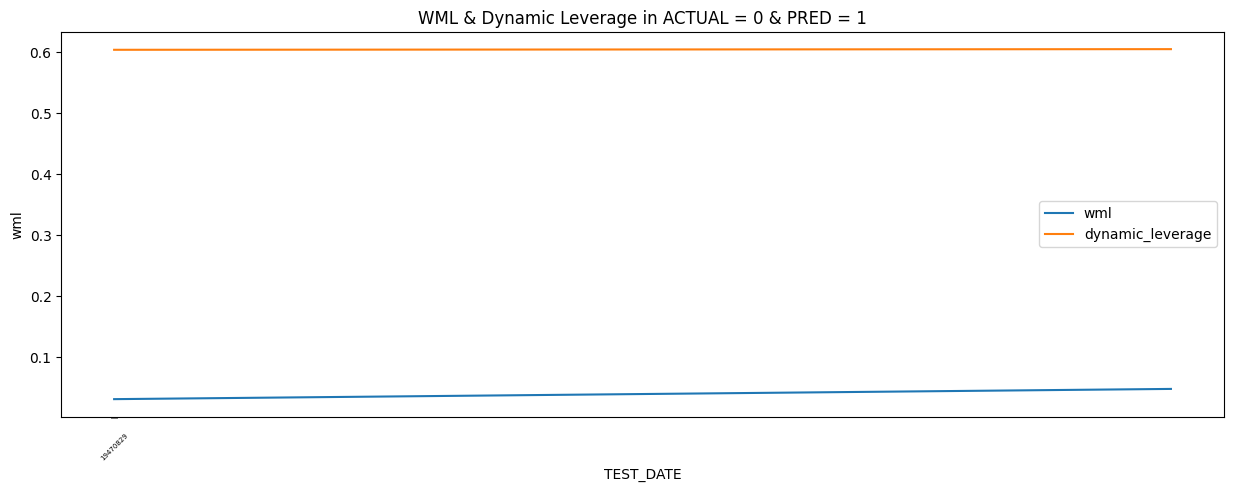

count      mean       var       std       min        1%       25%  \
wml    2.0  0.039023  0.000141  0.011863  0.030634  0.030802  0.034828   

          50%       75%       99%       max  
wml  0.039023  0.043217  0.047243  0.047411

count      mean           var       std       min        1%  \
dynamic_leverage    2.0  0.604301  5.676031e-07  0.000753  0.603768  0.603779   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.604035  0.604301  0.604567  0.604823  0.604834


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



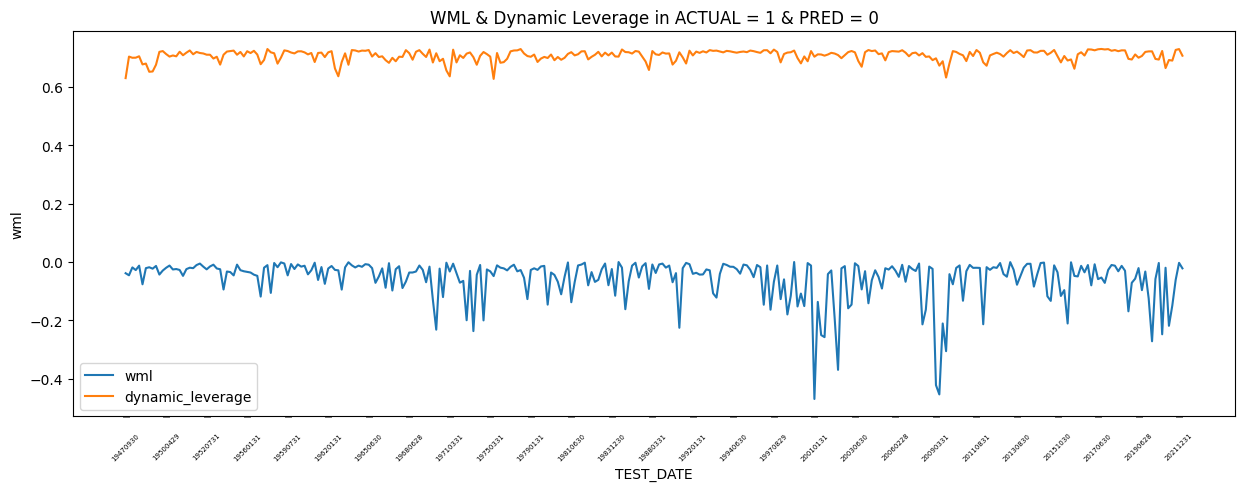

count      mean       var       std       min        1%      25%  \
wml  314.0 -0.056278  0.005106  0.071457 -0.469903 -0.361714 -0.06784   

          50%       75%       99%       max  
wml -0.028501 -0.014546 -0.000972 -0.000132

count      mean       var       std       min        1%  \
dynamic_leverage  314.0  0.708824  0.000341  0.018458  0.628114  0.636833   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.702747  0.714454  0.721927  0.730329  0.730752

In [142]:
plot_predict_result(Fixed_PCA_Result)


Top 5 dyn_mom



TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
20000229           19800229        20000131  0.330163          0.254214   
20010228           19810227        20010131  0.276912          0.246380   
20200331           20000331        20200228  0.229130          0.218144   
19991231           19791231        19991130  0.239571          0.216101   
20150731           19950731        20150630  0.209036          0.204146   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  \
TEST_DATE                                                                     
20000229           0.683513       0.769964               0                0   
20010228           0.708837       0.889741               0                0   
20200331           0.721528       0.952055               0                0   
19991231           0.711367       0.902032               0                0   
20150731           0.726435       0.976608               0                0   

             cum_return  
TEST_DATE                
20000229   32863.643175  
20010228   29353.554213  
20200331   65342.856306  
19991231   25655.171757  
20150731   41976.763956


Bottom 5 dyn_mom



TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
20010131           19810130        20001229 -0.469903         -0.407669   
20090331           19890331        20090227 -0.422400         -0.355233   
20021129           19821130        20021031 -0.370041         -0.331045   
20090430           19890428        20090331 -0.454349         -0.329231   
20200430           20000428        20200331 -0.271971         -0.260373   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  \
TEST_DATE                                                                     
20010131           0.704238       0.867560               1                0   
20090331           0.698673       0.840986               1                0   
20021129           0.709842       0.894619               1                0   
20090430           0.673624       0.724621               1                0   
20200430           0.722592       0.957357               1                0   

             cum_return  
TEST_DATE                
20010131   23550.855842  
20090331   50301.728075  
20021129   42178.709943  
20090430   33740.505219  
20200430   48329.062948

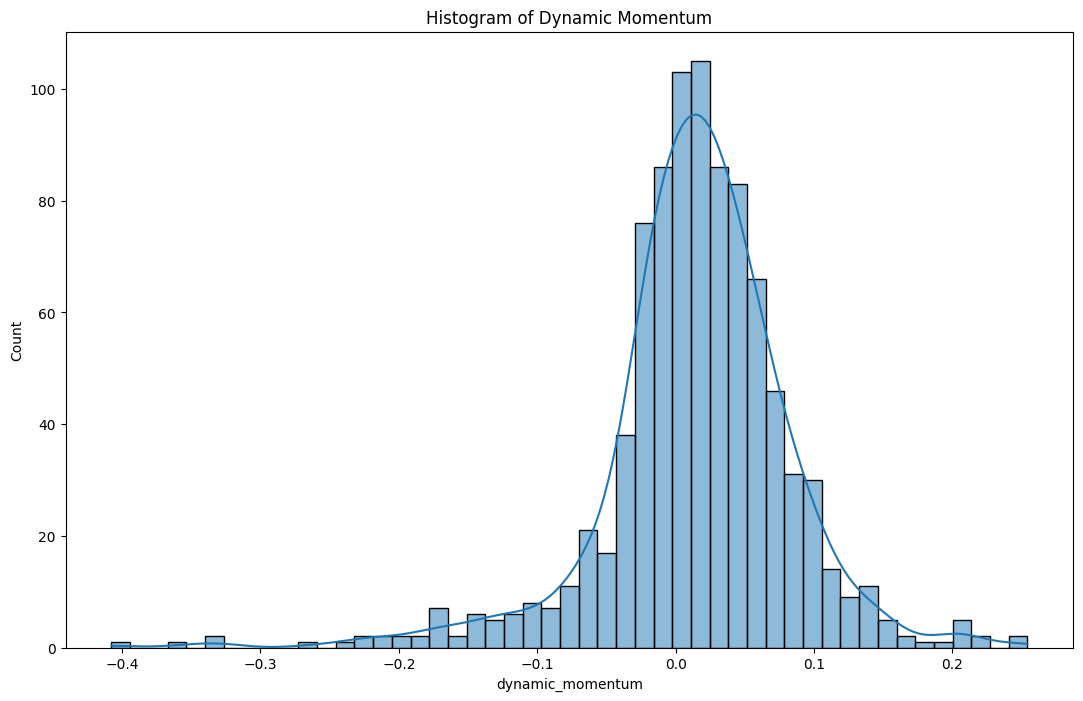

count      mean       var      std       min        1%  \
dynamic_momentum  906.0  0.015006  0.004623  0.06799 -0.407669 -0.211934   

                       25%      50%       75%       99%       max  
dynamic_momentum -0.014644  0.01683  0.051088  0.194213  0.254214

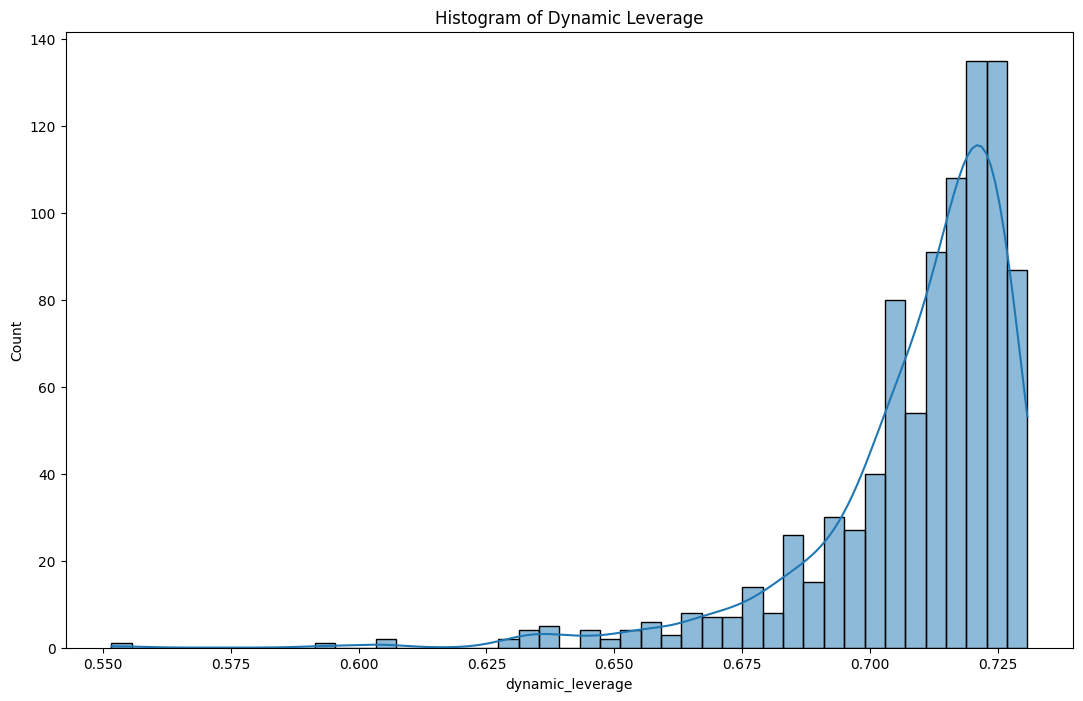

count      mean       var       std       min        1%  \
dynamic_leverage  906.0  0.709364  0.000405  0.020127  0.551695  0.634804   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.703411  0.715298  0.722667  0.729736  0.730752

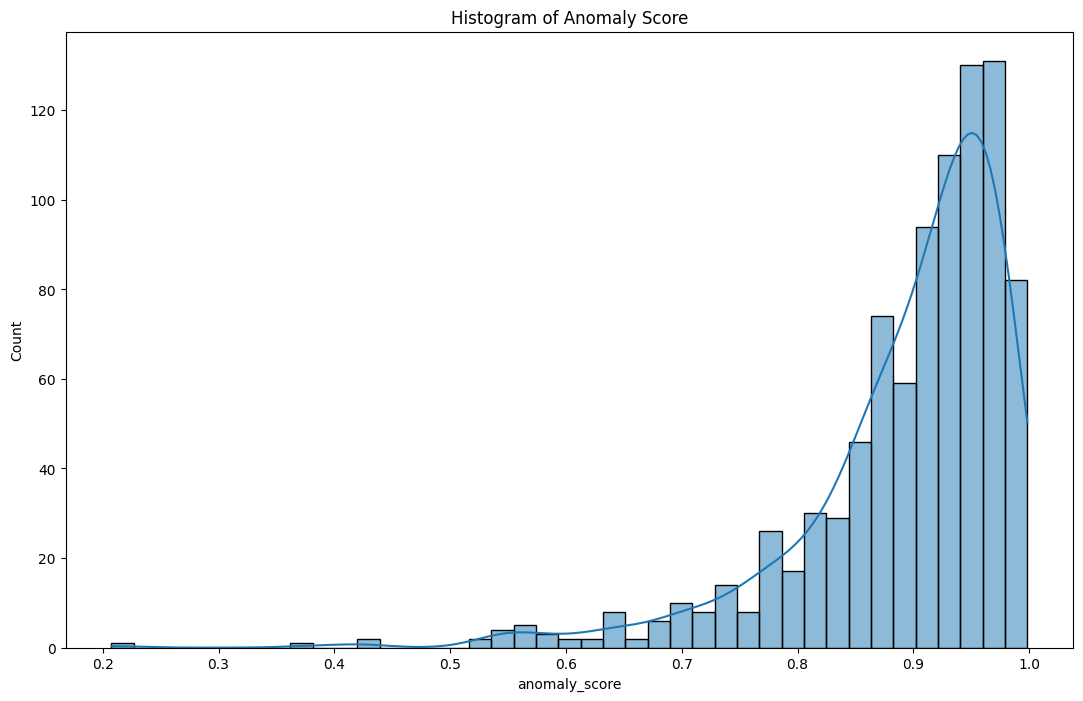

count      mean       var       std       min        1%  \
anomaly_score  906.0  0.894064  0.008854  0.094096  0.207523  0.552882   

                    25%       50%       75%       99%       max  
anomaly_score  0.863592  0.921256  0.957729  0.993286  0.998442

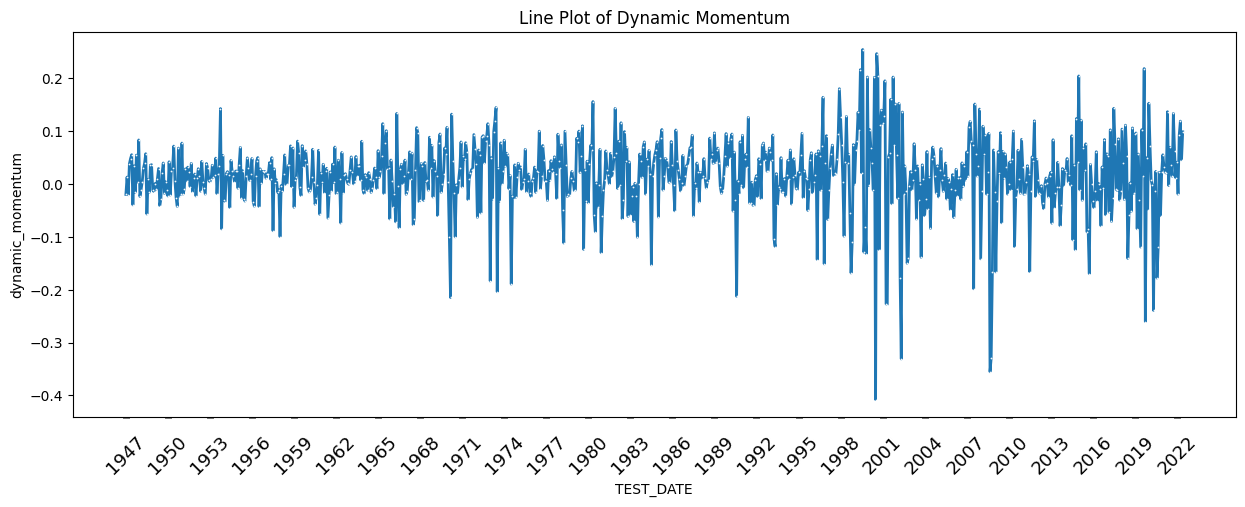

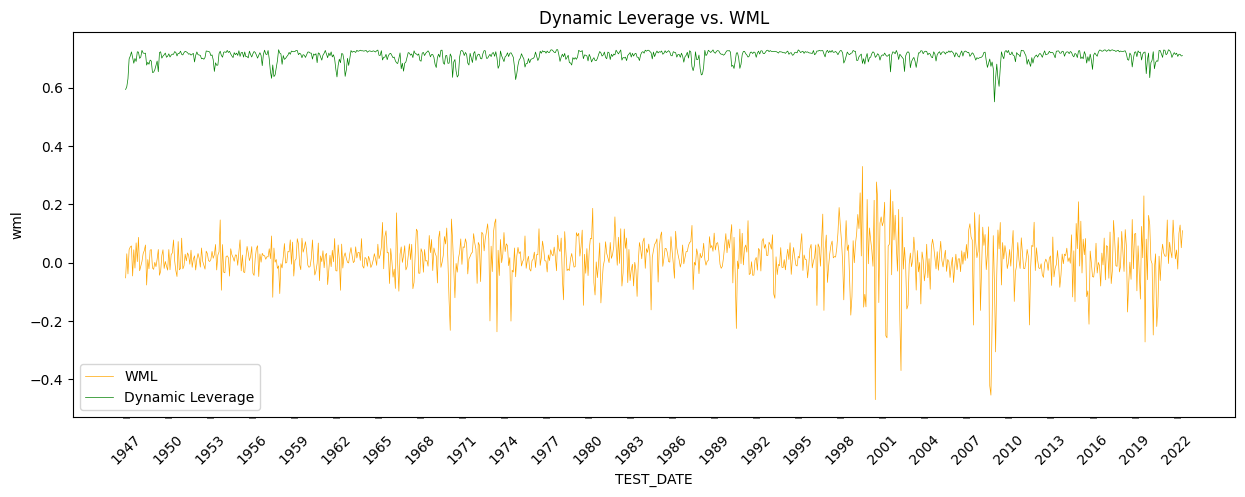

In [143]:
plot_dynamic_momentum(Fixed_PCA_Result)

## Sparse PCA

In [144]:
Sparse_PCA_Param={'n_components':1,
                  'alpha':0.1,
                  'random_state':42}
Sparse_PCA_MODEL = SparsePCA(**Sparse_PCA_Param)

In [145]:
Fixed_Sparse_PCA_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                         window_size=240, # window size (훈련 데이터 셋 크기)
                                         method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                         model=Sparse_PCA_MODEL,
                                         thr=0.50)

  0%|          | 0/906 [00:00<?, ?it/s]

In [146]:
Fixed_Sparse_PCA_Result.head(10)

TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
19470731           19270730        19470630 -0.052114         -0.017945   
19470829           19270831        19470731  0.030634          0.012306   
19470930           19270930        19470829 -0.038537         -0.021654   
19471031           19271031        19470930  0.044931          0.038851   
19471129           19271130        19471031  0.053920          0.048829   
19471231           19271231        19471129  0.057494          0.055130   
19480131           19280131        19471231 -0.045630         -0.038852   
19480228           19280229        19480131  0.044267          0.033553   
19480331           19280331        19480228 -0.018584         -0.015480   
19480430           19280430        19480331  0.067995          0.055352   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  
TEST_DATE                                                                    
19470731           0.585242       0.344331               1                1  
19470829           0.599097       0.401705               0                1  
19470930           0.636890       0.561892               1                0  
19471031           0.703638       0.864683               0                0  
19471129           0.712095       0.905579               0                0  
19471231           0.722898       0.958884               0                0  
19480131           0.700872       0.851452               1                0  
19480228           0.680912       0.757968               0                0  
19480331           0.696977       0.832943               1                0  
19480430           0.692975       0.814066               0                0

In [147]:
Fixed_Sparse_PCA_Result.loc[Fixed_Sparse_PCA_Result['static_leverage']==0]

TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
19470930           19270930        19470829 -0.038537         -0.021654   
19471031           19271031        19470930  0.044931          0.038851   
19471129           19271130        19471031  0.053920          0.048829   
19471231           19271231        19471129  0.057494          0.055130   
19480131           19280131        19471231 -0.045630         -0.038852   
...                     ...             ...       ...               ...   
20220831           20020830        20220729 -0.021856         -0.019049   
20220930           20020930        20220831  0.099930          0.090708   
20221031           20021031        20220930  0.129322          0.117552   
20221130           20021129        20221031  0.051291          0.045058   
20221230           20021231        20221130  0.109899          0.097356   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  
TEST_DATE                                                                    
19470930           0.636890       0.561892               1                0  
19471031           0.703638       0.864683               0                0  
19471129           0.712095       0.905579               0                0  
19471231           0.722898       0.958884               0                0  
19480131           0.700872       0.851452               1                0  
...                     ...            ...             ...              ...  
20220831           0.705071       0.871564               1                0  
20220930           0.712532       0.907712               0                0  
20221031           0.712793       0.908989               0                0  
20221130           0.706505       0.878471               0                0  
20221230           0.708037       0.885867               0                0  

[902 rows x 8 columns]

In [148]:
Fixed_Sparse_PCA_Result.loc[Fixed_Sparse_PCA_Result['static_leverage']==1]

TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
19470731           19270730        19470630 -0.052114         -0.017945   
19470829           19270831        19470731  0.030634          0.012306   
20090731           19890731        20090630 -0.070753         -0.016370   
20091130           19891130        20091030  0.047411          0.021106   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  
TEST_DATE                                                                    
19470731           0.585242       0.344331               1                1  
19470829           0.599097       0.401705               0                1  
20090731           0.557585       0.231366               1                1  
20091130           0.609489       0.445166               0                1

ORG Sharpe Ratio : 0.7293406994683723
ML Sharpe Ratio : 0.7700205581566484


최근 누적 수익률

  2022년-12월 -> 86674.18
  2022년-11월 -> 78984.45
  2022년-10월 -> 75578.97
  2022년-09월 -> 67628.93
  2022년-08월 -> 62004.56

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 86674.18
  2등 : 2022년-11월 -> 78984.45
  3등 : 2009년-02월 -> 76860.34
  4등 : 2002년-09월 -> 76280.74
  5등 : 2022년-10월 -> 75578.97
  6등 : 2009년-01월 -> 70502.36
  7등 : 2008년-11월 -> 70363.22
  8등 : 2008년-12월 -> 69070.89
  9등 : 2020년-03월 -> 68573.56
  10등 : 2002년-07월 -> 68046.75



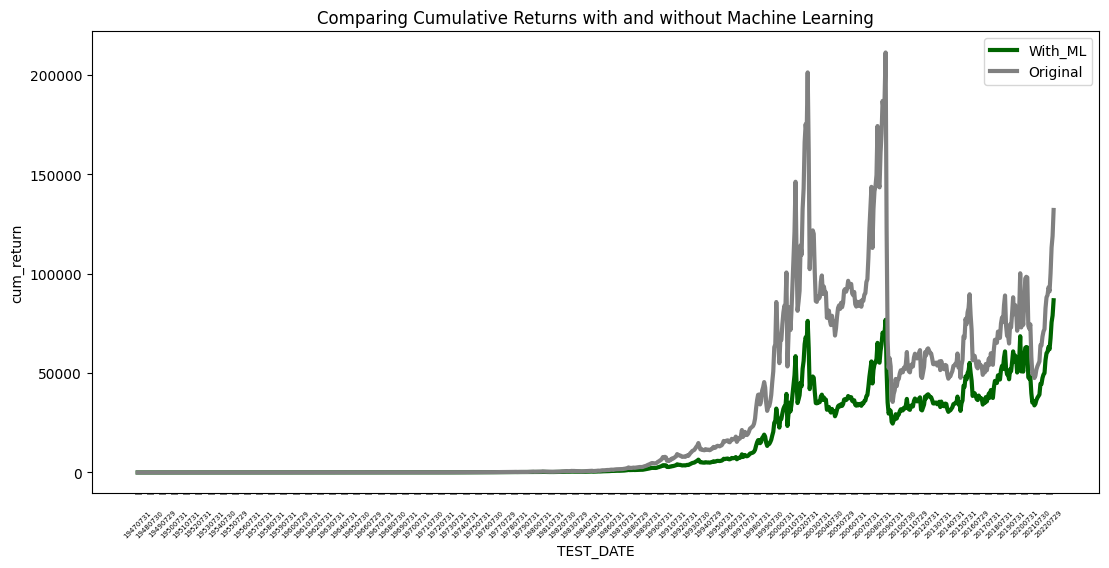

In [149]:
cum_return_sharpe_ratio(data=Fixed_Sparse_PCA_Result,
                        dynamic=True)


Performance results of the model

              precision    recall  f1-score   support

           0       0.65      1.00      0.79       590
           1       0.50      0.01      0.01       316

    accuracy                           0.65       906
   macro avg       0.58      0.50      0.40       906
weighted avg       0.60      0.65      0.52       906


accuracy : 0.6512141280353201

precision : 0.5

recall : 0.006329113924050633

F1-Score : 0.012499999999999999



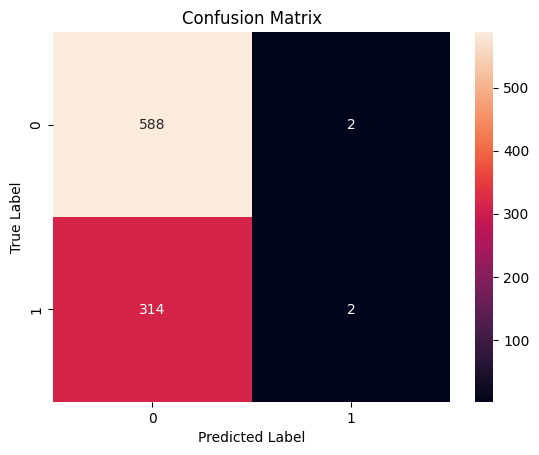


ACTUAL = PRED = 1



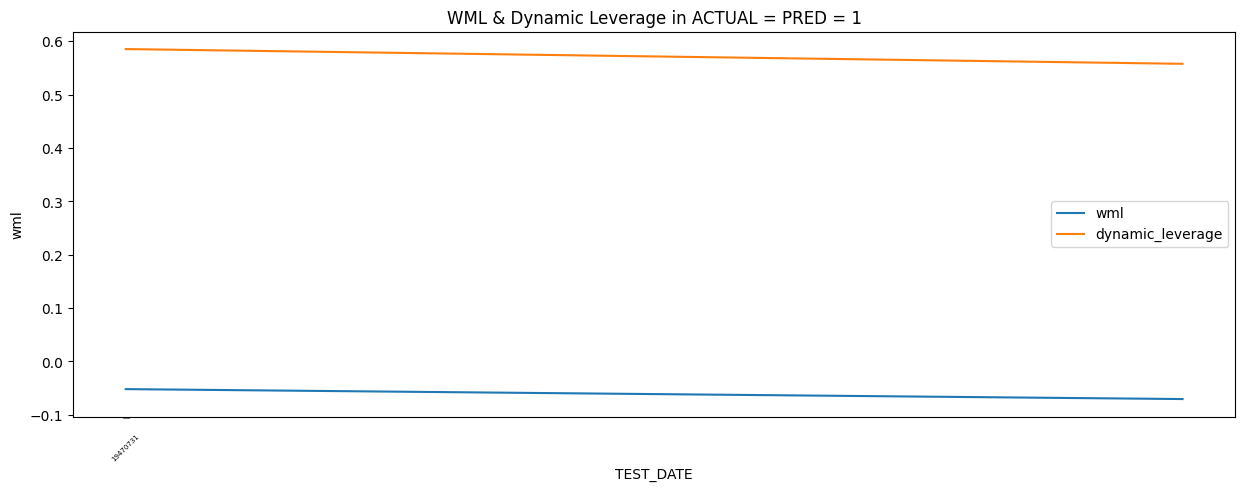

count      mean       var       std       min        1%       25%  \
wml    2.0 -0.061433  0.000174  0.013179 -0.070753 -0.070566 -0.066093   

          50%       75%       99%       max  
wml -0.061433 -0.056774 -0.052301 -0.052114

count      mean       var       std       min        1%  \
dynamic_leverage    2.0  0.571414  0.000382  0.019557  0.557585  0.557861   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.564499  0.571414  0.578328  0.584966  0.585242


--------------------------------------------------------------------------------


ACTUAL = PRED = 0



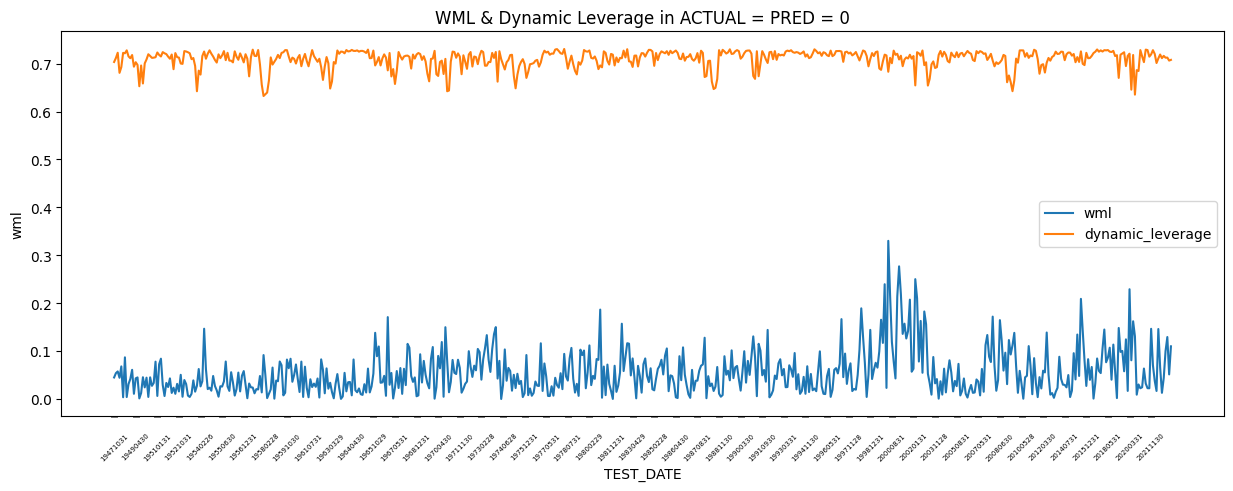

count      mean       var       std       min        1%       25%  \
wml  588.0  0.055305  0.002198  0.046879  0.000007  0.000687  0.021416   

         50%       75%      99%       max  
wml  0.04509  0.077301  0.21716  0.330163

count      mean       var       std       min        1%  \
dynamic_leverage  588.0  0.710155  0.000343  0.018513  0.632555  0.642609   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.703632  0.715348  0.722744  0.729611  0.730782


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



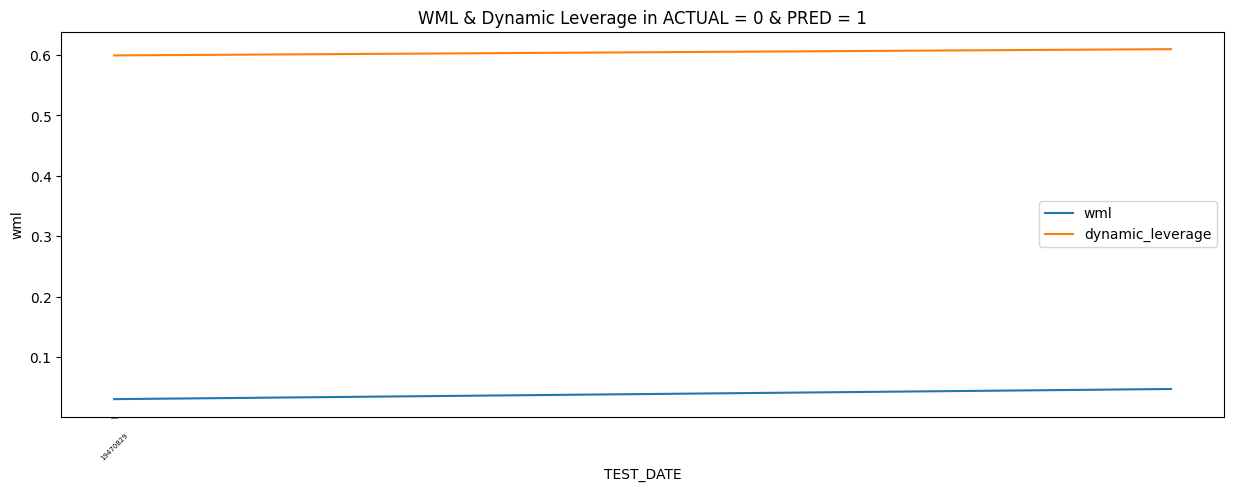

count      mean       var       std       min        1%       25%  \
wml    2.0  0.039023  0.000141  0.011863  0.030634  0.030802  0.034828   

          50%       75%       99%       max  
wml  0.039023  0.043217  0.047243  0.047411

count      mean       var       std       min        1%  \
dynamic_leverage    2.0  0.604293  0.000054  0.007348  0.599097  0.599201   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.601695  0.604293  0.606891  0.609385  0.609489


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



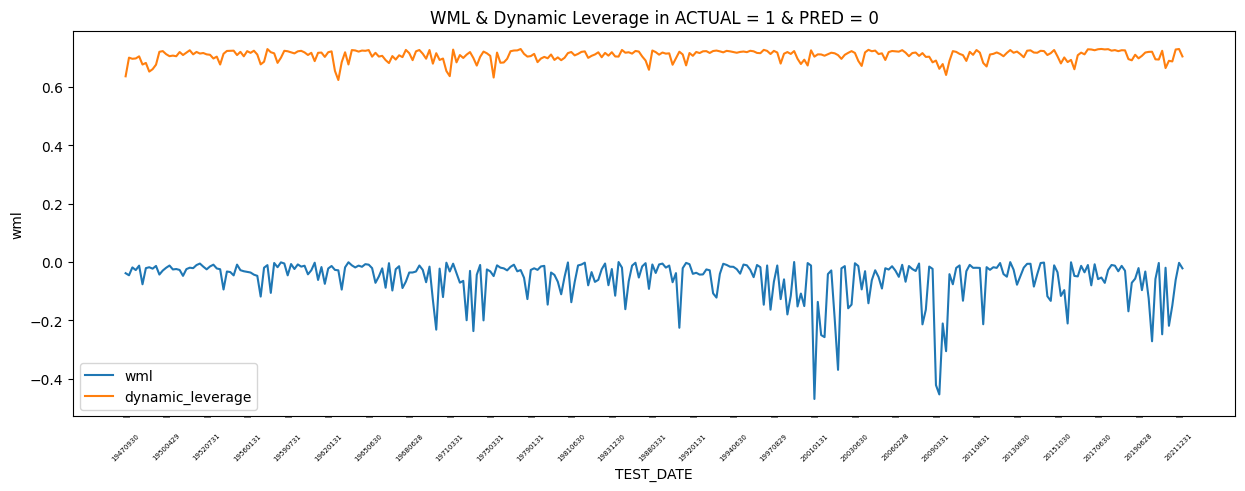

count      mean       var       std       min        1%      25%  \
wml  314.0 -0.056278  0.005106  0.071457 -0.469903 -0.361714 -0.06784   

          50%       75%       99%       max  
wml -0.028501 -0.014546 -0.000972 -0.000132

count      mean      var     std       min        1%  \
dynamic_leverage  314.0  0.708495  0.00035  0.0187  0.624208  0.637911   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.700737  0.714412  0.721664  0.730225  0.730664

In [150]:
plot_predict_result(Fixed_Sparse_PCA_Result)


Top 5 dyn_mom



TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
20000229           19800229        20000131  0.330163          0.253780   
20010228           19810227        20010131  0.276912          0.246412   
19991231           19791231        19991130  0.239571          0.225010   
20200331           20000331        20200228  0.229130          0.217461   
20150731           19950731        20150630  0.209036          0.203387   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  \
TEST_DATE                                                                     
20000229           0.683229       0.768651               0                0   
20010228           0.708861       0.889857               0                0   
19991231           0.718942       0.939222               0                0   
20200331           0.720929       0.949074               0                0   
20150731           0.725713       0.972979               0                0   

             cum_return  
TEST_DATE                
20000229   32152.651119  
20010228   29179.355245  
19991231   25104.337347  
20200331   68573.563566  
20150731   43624.552671


Bottom 5 dyn_mom



TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
20010131           19810130        20001229 -0.469903         -0.407845   
20090331           19890331        20090227 -0.422400         -0.339625   
20021129           19821130        20021031 -0.370041         -0.330577   
20090430           19890428        20090331 -0.454349         -0.306699   
20200430           20000428        20200331 -0.271971         -0.258437   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  \
TEST_DATE                                                                     
20010131           0.704316       0.867935               1                0   
20090331           0.690837       0.804036               1                0   
20021129           0.709582       0.893353               1                0   
20090430           0.662628       0.675029               1                0   
20200430           0.721163       0.950236               1                0   

             cum_return  
TEST_DATE                
20010131   23410.486211  
20090331   50756.320453  
20021129   41949.907382  
20090430   35189.114870  
20200430   50851.387493

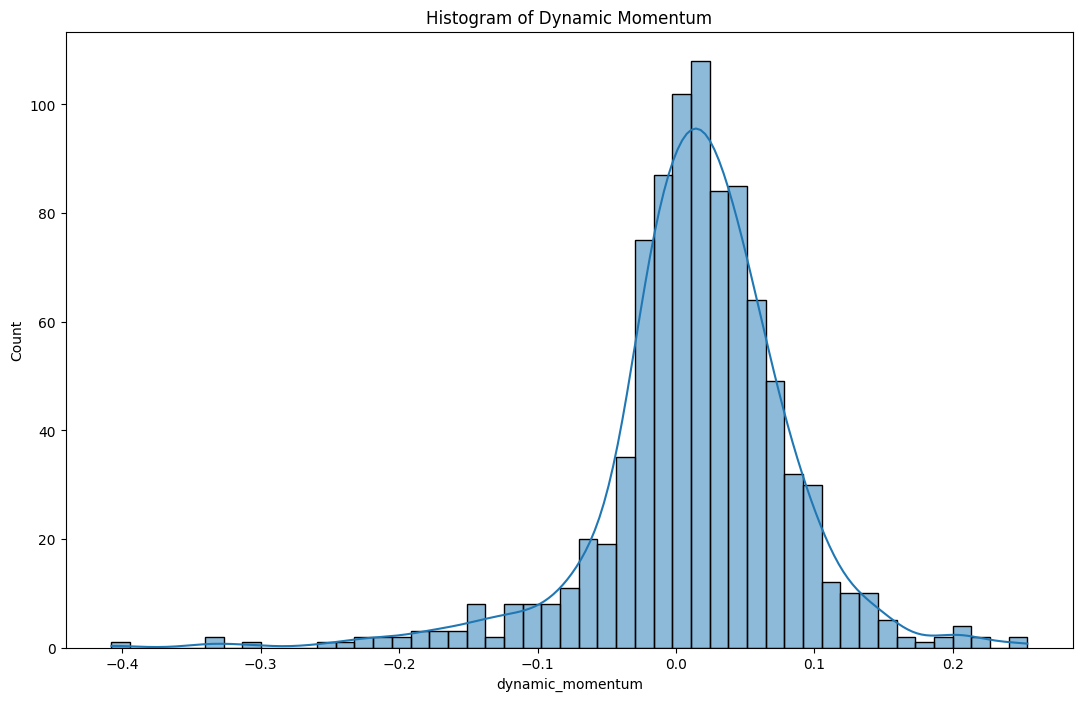

count      mean       var       std       min        1%  \
dynamic_momentum  906.0  0.015026  0.004569  0.067597 -0.407845 -0.213827   

                       25%       50%      75%       99%      max  
dynamic_momentum -0.014725  0.016325  0.05111  0.193584  0.25378

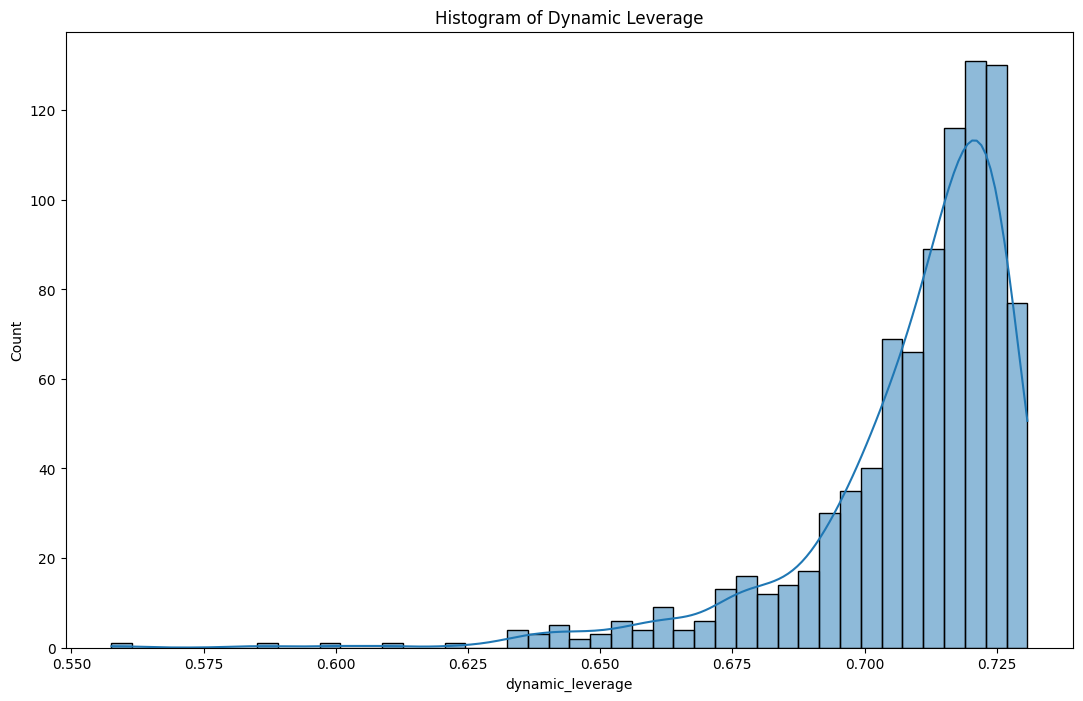

count     mean       var       std       min        1%  \
dynamic_leverage  906.0  0.70904  0.000411  0.020267  0.557585  0.636914   

                       25%       50%       75%      99%       max  
dynamic_leverage  0.703117  0.715045  0.722566  0.72997  0.730782

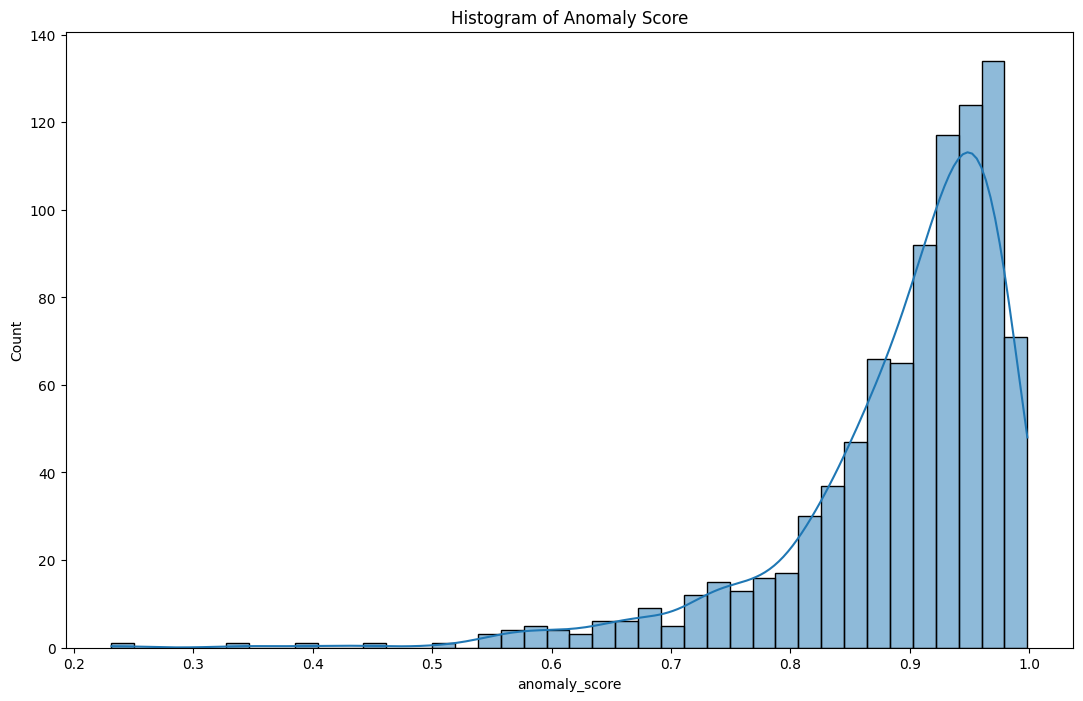

count      mean       var       std       min        1%  \
anomaly_score  906.0  0.892515  0.008978  0.094753  0.231366  0.561997   

                    25%       50%       75%       99%       max  
anomaly_score  0.862184  0.920012  0.957227  0.994468  0.998592

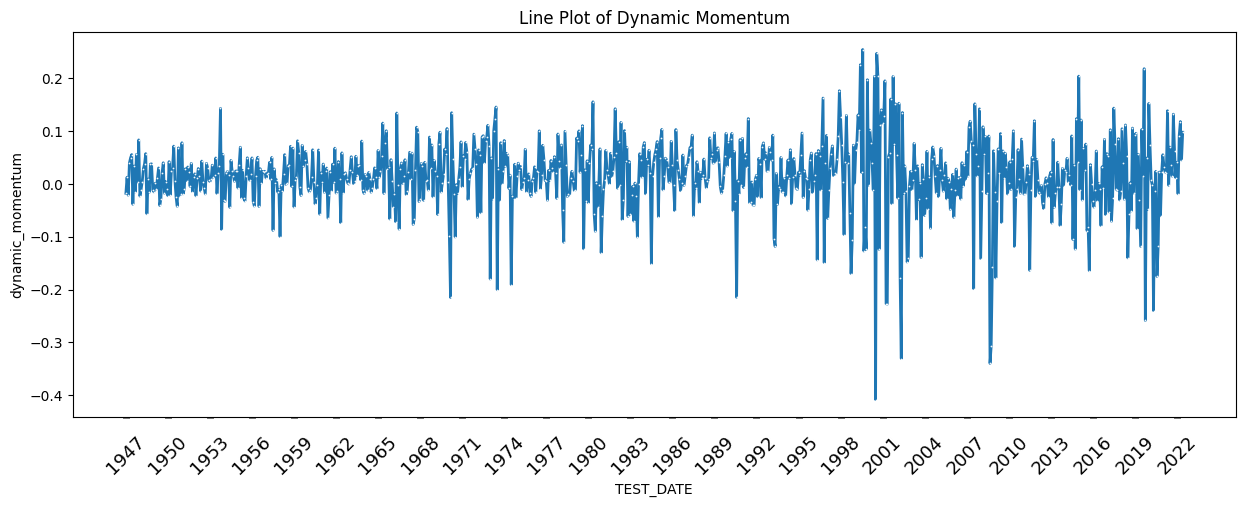

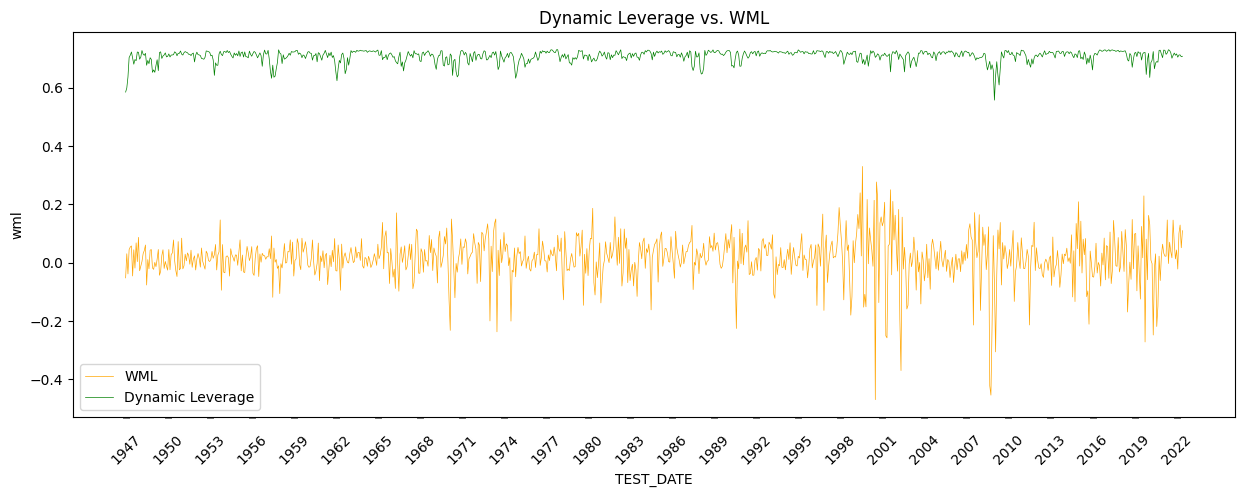

In [151]:
plot_dynamic_momentum(Fixed_Sparse_PCA_Result)

## Kernel PCA

In [153]:
Kernel_PCA_Param={'n_components':1,
                  'kernel':'poly',
                  'gamma':1/12,
                  'fit_inverse_transform':True,
                  'random_state':42}
Kernel_PCA_MODEL = KernelPCA(**Kernel_PCA_Param)

In [154]:
Fixed_Kernel_PCA_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                          window_size=240, # window size (훈련 데이터 셋 크기)
                                          method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                          model=Kernel_PCA_MODEL,
                                          thr=0.50)

  0%|          | 0/906 [00:00<?, ?it/s]

In [155]:
Fixed_Kernel_PCA_Result.head(10)

TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
19470731           19270730        19470630 -0.052114         -0.023695   
19470829           19270831        19470731  0.030634          0.014861   
19470930           19270930        19470829 -0.038537         -0.018478   
19471031           19271031        19470930  0.044931          0.031298   
19471129           19271130        19471031  0.053920          0.043030   
19471231           19271231        19471129  0.057494          0.055751   
19480131           19280131        19471231 -0.045630         -0.040977   
19480228           19280229        19480131  0.044267          0.034933   
19480331           19280331        19480228 -0.018584         -0.016367   
19480430           19280430        19480331  0.067995          0.054043   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  
TEST_DATE                                                                    
19470731           0.611752       0.454681               1                1  
19470829           0.618952       0.485101               0                1  
19470930           0.617628       0.479493               1                1  
19471031           0.667430       0.696586               0                0  
19471129           0.689553       0.798029               0                0  
19471231           0.725057       0.969686               0                0  
19480131           0.710544       0.898027               1                0  
19480228           0.687651       0.789160               0                0  
19480331           0.706964       0.880683               1                0  
19480430           0.688863       0.794807               0                0

In [156]:
Fixed_Kernel_PCA_Result.loc[Fixed_Kernel_PCA_Result['static_leverage']==0]

TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
19471031           19271031        19470930  0.044931          0.031298   
19471129           19271130        19471031  0.053920          0.043030   
19471231           19271231        19471129  0.057494          0.055751   
19480131           19280131        19471231 -0.045630         -0.040977   
19480228           19280229        19480131  0.044267          0.034933   
...                     ...             ...       ...               ...   
20220831           20020830        20220729 -0.021856         -0.018179   
20220930           20020930        20220831  0.099930          0.086933   
20221031           20021031        20220930  0.129322          0.113350   
20221130           20021129        20221031  0.051291          0.042707   
20221230           20021231        20221130  0.109899          0.094179   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  
TEST_DATE                                                                    
19471031           0.667430       0.696586               0                0  
19471129           0.689553       0.798029               0                0  
19471231           0.725057       0.969686               0                0  
19480131           0.710544       0.898027               1                0  
19480228           0.687651       0.789160               0                0  
...                     ...            ...             ...              ...  
20220831           0.696727       0.831761               1                0  
20220930           0.704734       0.869943               0                0  
20221031           0.706096       0.876497               0                0  
20221130           0.696913       0.832639               0                0  
20221230           0.702025       0.856958               0                0  

[897 rows x 8 columns]

In [157]:
Fixed_Kernel_PCA_Result.loc[Fixed_Kernel_PCA_Result['static_leverage']==1]

TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
19470731           19270730        19470630 -0.052114         -0.023695   
19470829           19270831        19470731  0.030634          0.014861   
19470930           19270930        19470829 -0.038537         -0.018478   
19620831           19420831        19620731 -0.028629         -0.013788   
19630329           19430331        19630228  0.033848          0.014170   
19701130           19501130        19701030  0.078579          0.031086   
20090731           19890731        20090630 -0.070753         -0.014396   
20090831           19890831        20090731 -0.305990         -0.149262   
20091130           19891130        20091030  0.047411          0.020218   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  
TEST_DATE                                                                    
19470731           0.611752       0.454681               1                1  
19470829           0.618952       0.485101               0                1  
19470930           0.617628       0.479493               1                1  
19620831           0.618123       0.481591               1                1  
19630329           0.603156       0.418632               0                1  
19701130           0.597629       0.395594               0                1  
20090731           0.550691       0.203465               1                1  
20090831           0.619589       0.487802               1                1  
20091130           0.605022       0.426437               0                1

ORG Sharpe Ratio : 0.7293406994683723
ML Sharpe Ratio : 0.7798662336867724


최근 누적 수익률

  2022년-12월 -> 80726.93
  2022년-11월 -> 73778.44
  2022년-10월 -> 70756.59
  2022년-09월 -> 63552.76
  2022년-08월 -> 58469.71

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 80726.93
  2등 : 2022년-11월 -> 73778.44
  3등 : 2022년-10월 -> 70756.59
  4등 : 2009년-02월 -> 66928.56
  5등 : 2020년-03월 -> 65095.83
  6등 : 2002년-09월 -> 64722.06
  7등 : 2022년-09월 -> 63552.76
  8등 : 2009년-01월 -> 61591.86
  9등 : 2008년-11월 -> 61443.11
  10등 : 2008년-12월 -> 60387.42



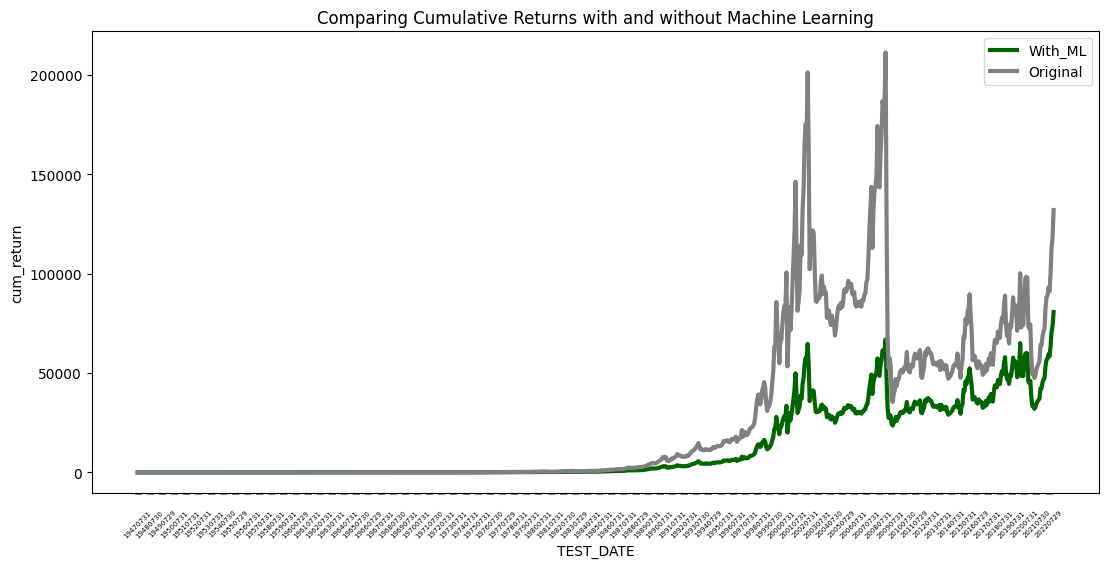

In [158]:
cum_return_sharpe_ratio(data=Fixed_Kernel_PCA_Result,
                        dynamic=True)


Performance results of the model

              precision    recall  f1-score   support

           0       0.65      0.99      0.79       590
           1       0.56      0.02      0.03       316

    accuracy                           0.65       906
   macro avg       0.60      0.50      0.41       906
weighted avg       0.62      0.65      0.52       906


accuracy : 0.652317880794702

precision : 0.5555555555555556

recall : 0.015822784810126583

F1-Score : 0.030769230769230774



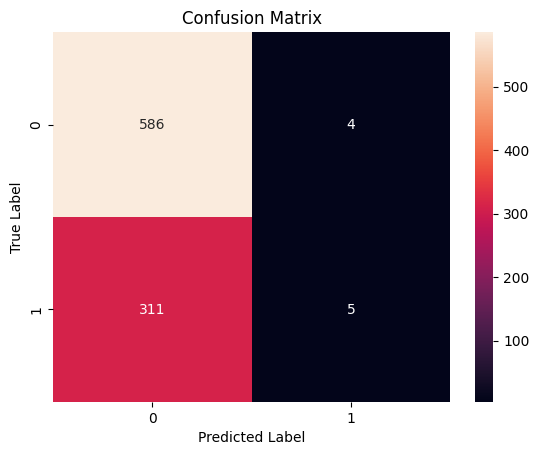


ACTUAL = PRED = 1



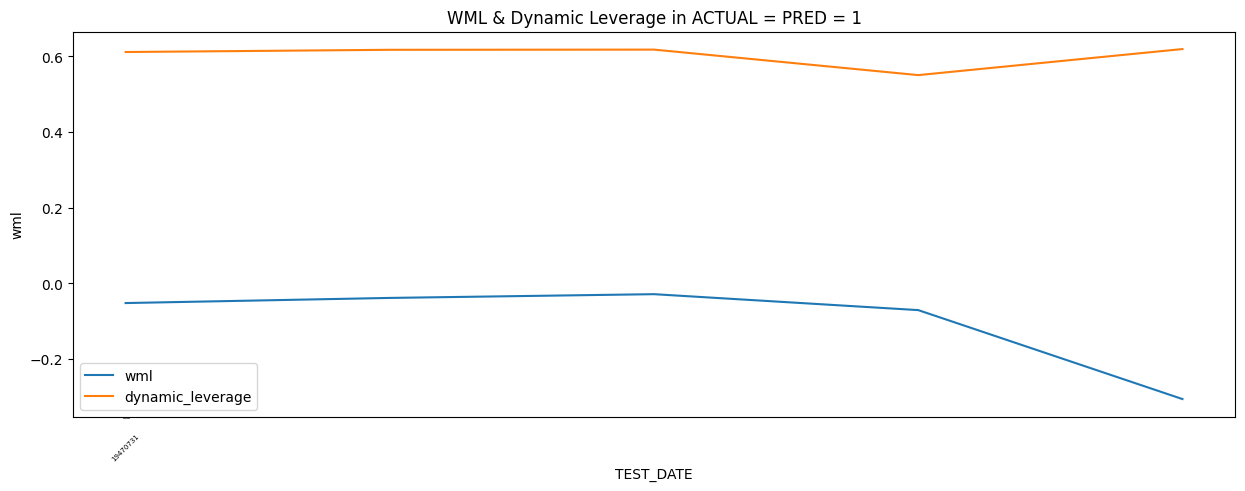

count      mean       var       std      min       1%       25%  \
wml    5.0 -0.099205  0.013612  0.116671 -0.30599 -0.29658 -0.070753   

          50%       75%       99%       max  
wml -0.052114 -0.038537 -0.029026 -0.028629

count      mean       var       std       min        1%  \
dynamic_leverage    5.0  0.603557  0.000882  0.029703  0.550691  0.553134   

                       25%       50%       75%      99%       max  
dynamic_leverage  0.611752  0.617628  0.618123  0.61953  0.619589


--------------------------------------------------------------------------------


ACTUAL = PRED = 0



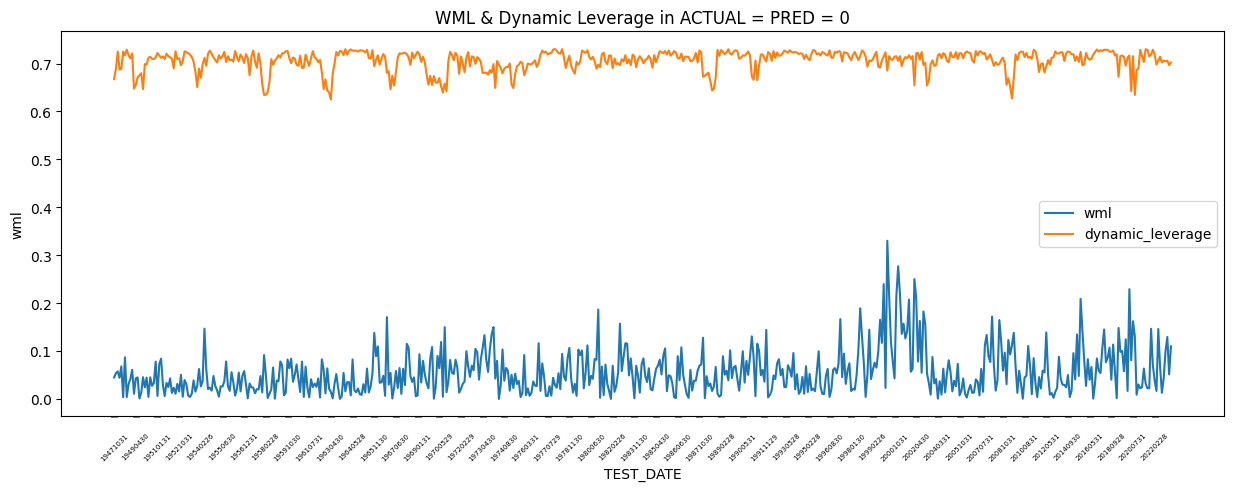

count      mean       var      std       min        1%       25%  \
wml  586.0  0.055302  0.002203  0.04694  0.000007  0.000686  0.021288   

         50%       75%       99%       max  
wml  0.04509  0.076982  0.217202  0.330163

count      mean       var       std       min       1%  \
dynamic_leverage  586.0  0.706482  0.000425  0.020627  0.624963  0.63973   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.698847  0.712271  0.721446  0.729473  0.730469


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



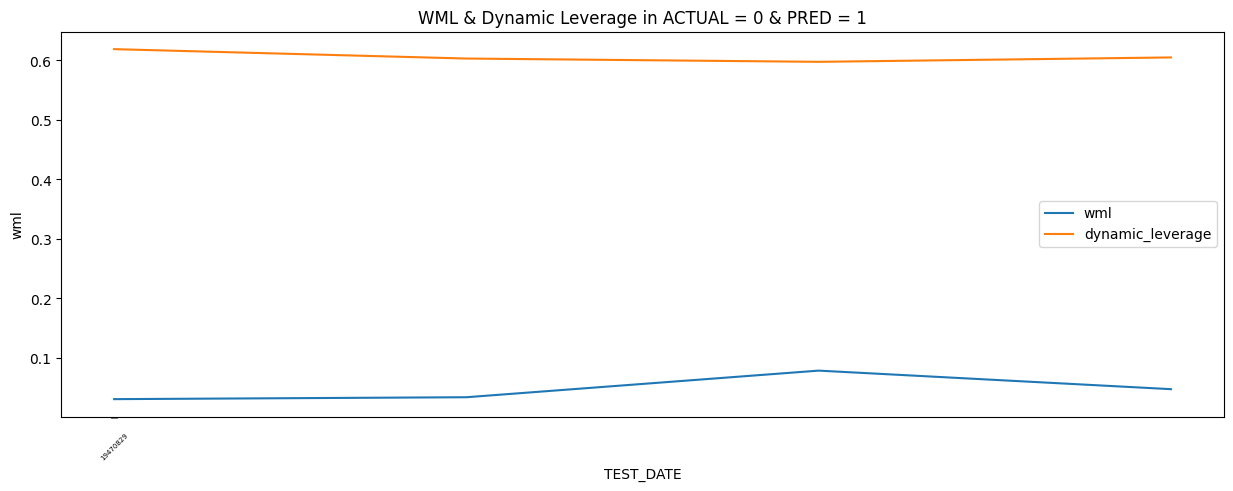

count      mean       var       std       min        1%       25%  \
wml    4.0  0.047618  0.000479  0.021884  0.030634  0.030731  0.033045   

         50%       75%       99%       max  
wml  0.04063  0.055203  0.077644  0.078579

count     mean       var       std       min        1%  \
dynamic_leverage    4.0  0.60619  0.000082  0.009069  0.597629  0.597795   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.601774  0.604089  0.608505  0.618534  0.618952


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



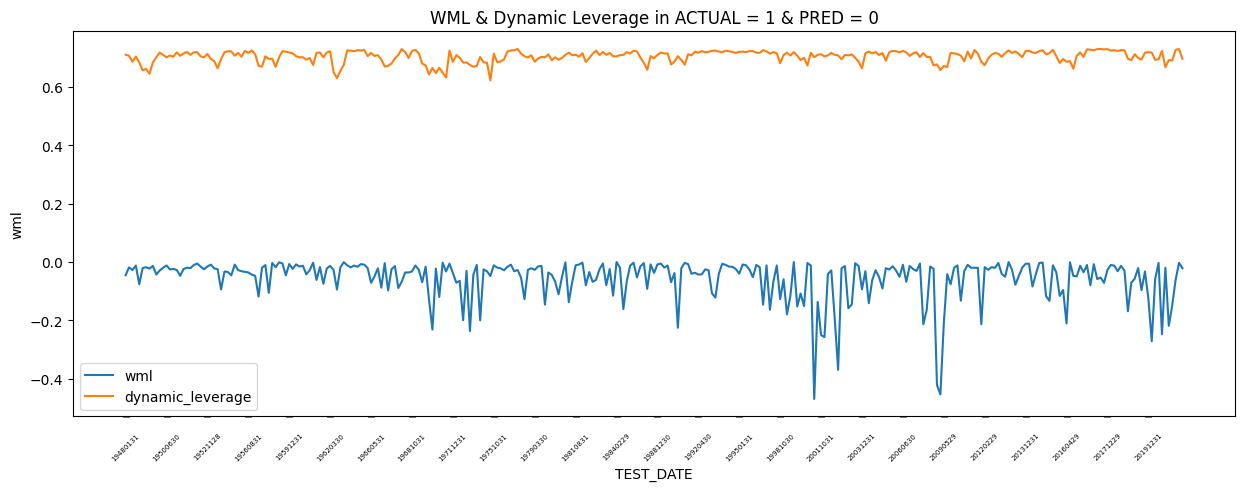

count      mean      var      std       min        1%       25%  \
wml  311.0 -0.055621  0.00495  0.07036 -0.469903 -0.360234 -0.067835   

          50%       75%       99%       max  
wml -0.028359 -0.014359 -0.000969 -0.000132

count      mean       var       std       min        1%  \
dynamic_leverage  311.0  0.704651  0.000403  0.020086  0.622653  0.643388   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.695765  0.709866  0.719372  0.729862  0.730325

In [159]:
plot_predict_result(Fixed_Kernel_PCA_Result)


Top 5 dyn_mom



TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
20000229           19800229        20000131  0.330163          0.256937   
20010228           19810227        20010131  0.276912          0.241901   
19991231           19791231        19991130  0.239571          0.219532   
20200331           20000331        20200228  0.229130          0.212838   
20010330           19810331        20010228  0.219012          0.202015   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  \
TEST_DATE                                                                     
20000229           0.685295       0.778212               0                0   
20010228           0.705487       0.873566               0                0   
19991231           0.714298       0.916353               0                0   
20200331           0.716851       0.928896               0                0   
20010330           0.715530       0.922395               0                0   

             cum_return  
TEST_DATE                
20000229   28001.047354  
20010228   24905.260295  
19991231   21791.984745  
20200331   65095.830517  
20010330   29936.703324


Bottom 5 dyn_mom



TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
20010131           19810130        20001229 -0.469903         -0.402387   
20021129           19821130        20021031 -0.370041         -0.328326   
20090331           19890331        20090227 -0.422400         -0.313555   
20090430           19890428        20090331 -0.454349         -0.297645   
20200430           20000428        20200331 -0.271971         -0.253782   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  \
TEST_DATE                                                                     
20010131           0.701891       0.856319               1                0   
20021129           0.708326       0.887270               1                0   
20090331           0.677503       0.742319               1                0   
20090430           0.658159       0.655101               1                0   
20200430           0.717708       0.933122               1                0   

             cum_return  
TEST_DATE                
20010131   20053.953923  
20021129   35942.722943  
20090331   45942.431585  
20090430   32267.617069  
20200430   48575.422545

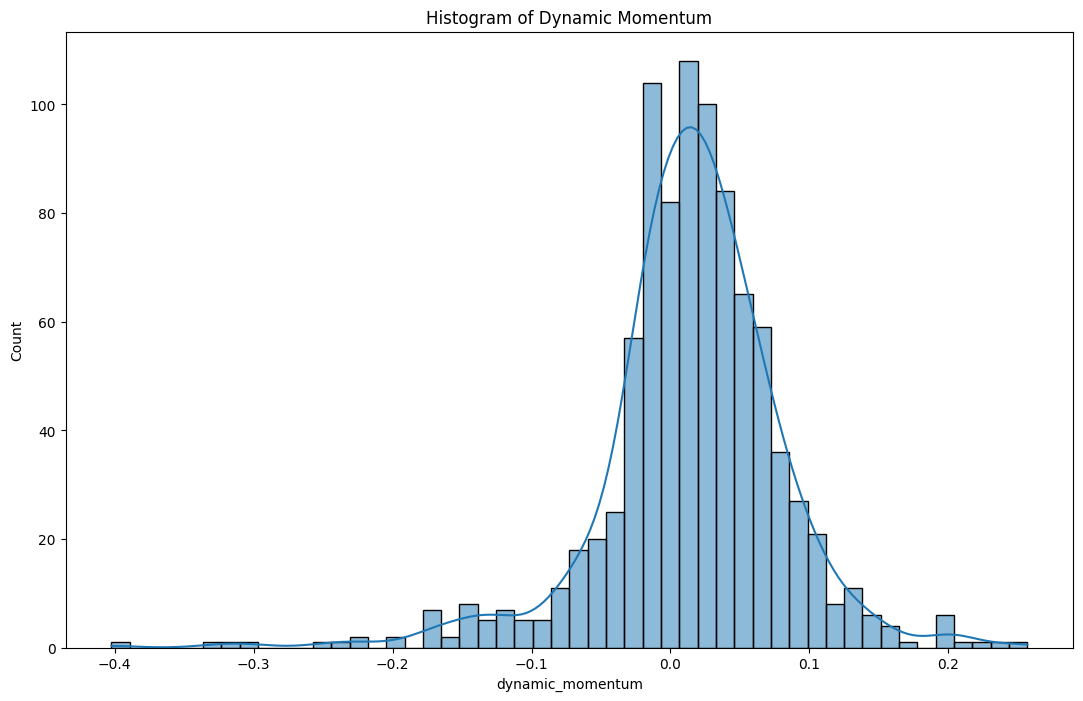

count     mean       var       std       min        1%  \
dynamic_momentum  906.0  0.01481  0.004328  0.065786 -0.402387 -0.196334   

                       25%       50%       75%       99%       max  
dynamic_momentum -0.013738  0.016146  0.050248  0.192253  0.256937

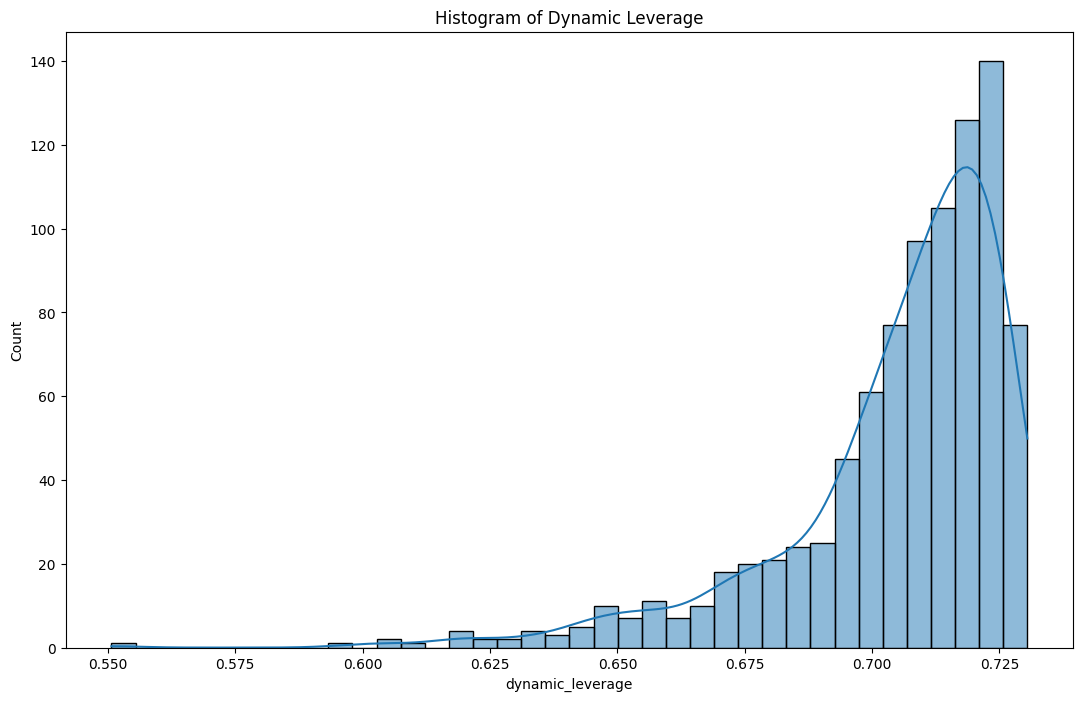

count      mean       var       std       min        1%  \
dynamic_leverage  906.0  0.704843  0.000519  0.022778  0.550691  0.622769   

                      25%     50%      75%       99%       max  
dynamic_leverage  0.69757  0.7112  0.72053  0.729804  0.730469

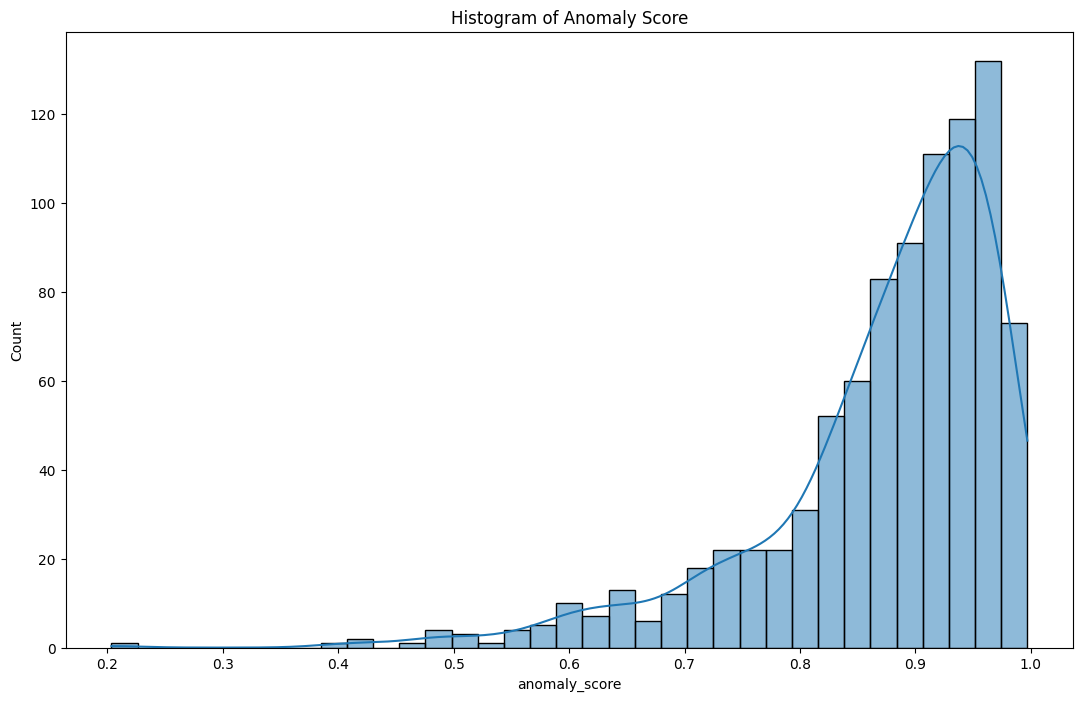

count      mean       var       std       min        1%  \
anomaly_score  906.0  0.872658  0.011222  0.105934  0.203465  0.501318   

                    25%       50%       75%      99%       max  
anomaly_score  0.835753  0.901219  0.947093  0.99363  0.997002

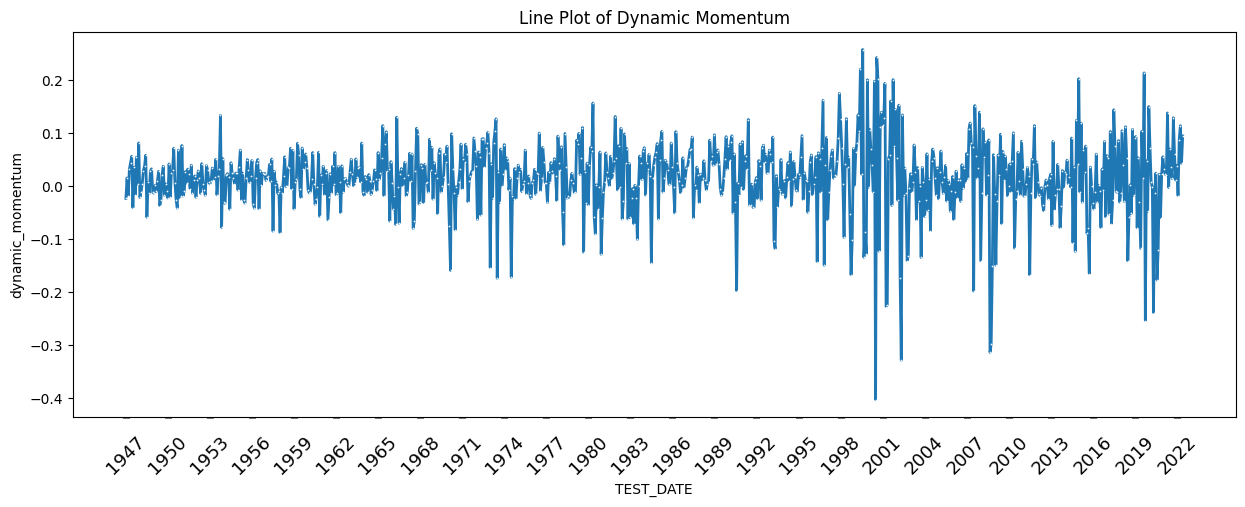

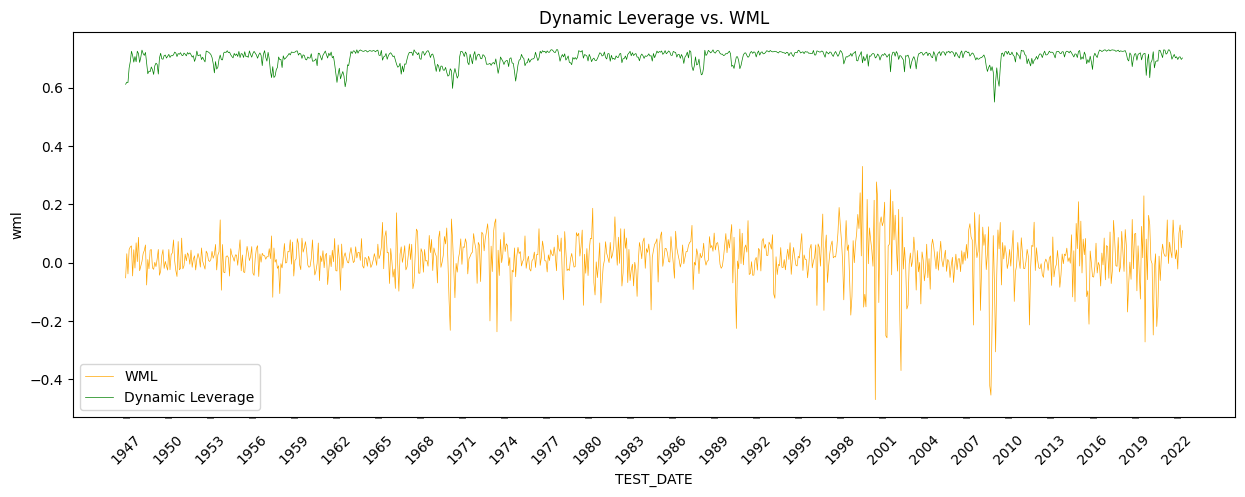

In [160]:
plot_dynamic_momentum(Fixed_Kernel_PCA_Result)

## GRP

In [162]:
GRP_Param={'n_components':1,
           'random_state':42}
GRP_MODEL = GaussianRandomProjection(**GRP_Param)

In [163]:
Fixed_GRP_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=GRP_MODEL,
                                  thr=0.50)

  0%|          | 0/906 [00:00<?, ?it/s]

In [164]:
Fixed_GRP_Result.head(10)

TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
19470731           19270730        19470630 -0.052114         -0.007164   
19470829           19270831        19470731  0.030634          0.008776   
19470930           19270930        19470829 -0.038537         -0.017289   
19471031           19271031        19470930  0.044931          0.018122   
19471129           19271130        19471031  0.053920          0.021210   
19471231           19271231        19471129  0.057494          0.019366   
19480131           19280131        19471231 -0.045630         -0.017267   
19480228           19280229        19480131  0.044267          0.020986   
19480331           19280331        19480228 -0.018584         -0.005717   
19480430           19280430        19480331  0.067995          0.008002   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  
TEST_DATE                                                                    
19470731           0.534313       0.137467               1                1  
19470829           0.571133       0.286476               0                1  
19470930           0.610312       0.448623               1                1  
19471031           0.599489       0.403337               0                1  
19471129           0.597090       0.393355               0                1  
19471231           0.583424       0.336844               0                1  
19480131           0.593492       0.378420               1                1  
19480228           0.616348       0.474077               0                1  
19480331           0.576307       0.307630               1                1  
19480430           0.529388       0.117689               0                1

In [165]:
Fixed_GRP_Result.loc[Fixed_GRP_Result['static_leverage']==0]

TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
19480730           19280731        19480630 -0.027746         -0.015762   
19480831           19280831        19480730 -0.012545         -0.007697   
19491130           19291127        19491031  0.045364          0.025794   
19500228           19300228        19500131  0.024176          0.013954   
19500331           19300331        19500228  0.044468          0.024350   
...                     ...             ...       ...               ...   
20161130           19961129        20161031 -0.035448         -0.019227   
20200831           20000831        20200731  0.130803          0.072162   
20201030           20001031        20200930 -0.003446         -0.001779   
20210226           20010228        20210129 -0.218901         -0.113456   
20210331           20010330        20210226 -0.149329         -0.083214   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  
TEST_DATE                                                                    
19480730           0.638323       0.568095               1                0  
19480831           0.648763       0.613608               1                0  
19491130           0.638441       0.568602               0                0  
19500228           0.640413       0.577158               0                0  
19500331           0.633576       0.547589               0                0  
...                     ...            ...             ...              ...  
20161130           0.632371       0.542400               1                0  
20200831           0.634526       0.551683               0                0  
20201030           0.626301       0.516380               1                0  
20210226           0.626749       0.518297               1                0  
20210331           0.635816       0.557252               1                0  

[93 rows x 8 columns]

In [166]:
Fixed_GRP_Result.loc[Fixed_GRP_Result['static_leverage']==1]

TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
19470731           19270730        19470630 -0.052114         -0.007164   
19470829           19270831        19470731  0.030634          0.008776   
19470930           19270930        19470829 -0.038537         -0.017289   
19471031           19271031        19470930  0.044931          0.018122   
19471129           19271130        19471031  0.053920          0.021210   
...                     ...             ...       ...               ...   
20220831           20020830        20220729 -0.021856         -0.001999   
20220930           20020930        20220831  0.099930          0.018915   
20221031           20021031        20220930  0.129322          0.030048   
20221130           20021129        20221031  0.051291          0.010402   
20221230           20021231        20221130  0.109899          0.022737   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  
TEST_DATE                                                                    
19470731           0.534313       0.137467               1                1  
19470829           0.571133       0.286476               0                1  
19470930           0.610312       0.448623               1                1  
19471031           0.599489       0.403337               0                1  
19471129           0.597090       0.393355               0                1  
...                     ...            ...             ...              ...  
20220831           0.522851       0.091468               1                1  
20220930           0.547181       0.189287               0                1  
20221031           0.557827       0.232348               0                1  
20221130           0.550529       0.202808               0                1  
20221230           0.551540       0.206893               0                1  

[813 rows x 8 columns]

ORG Sharpe Ratio : 0.7293406994683723
ML Sharpe Ratio : 0.8116413602385976


최근 누적 수익률

  2022년-12월 -> 116.41
  2022년-11월 -> 113.80
  2022년-10월 -> 112.62
  2022년-09월 -> 109.31
  2022년-08월 -> 107.26

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2020년-09월 -> 132.44
  2등 : 2020년-10월 -> 132.21
  3등 : 2020년-08월 -> 131.85
  4등 : 2020년-03월 -> 125.26
  5등 : 2020년-07월 -> 122.91
  6등 : 2020년-05월 -> 118.08
  7등 : 2021년-01월 -> 117.88
  8등 : 2020년-04월 -> 117.40
  9등 : 2020년-06월 -> 117.37
  10등 : 2020년-11월 -> 117.28



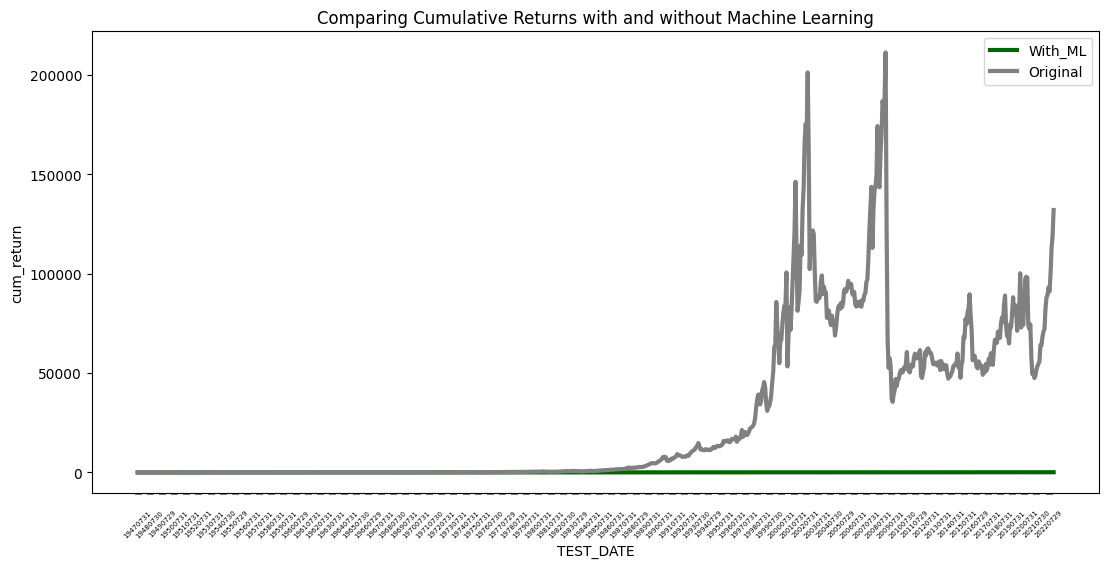

In [167]:
cum_return_sharpe_ratio(data=Fixed_GRP_Result,
                        dynamic=True)


Performance results of the model

              precision    recall  f1-score   support

           0       0.63      0.10      0.17       590
           1       0.35      0.89      0.50       316

    accuracy                           0.38       906
   macro avg       0.49      0.50      0.34       906
weighted avg       0.53      0.38      0.29       906


accuracy : 0.37637969094922735

precision : 0.34686346863468637

recall : 0.8924050632911392

F1-Score : 0.4995571302037201



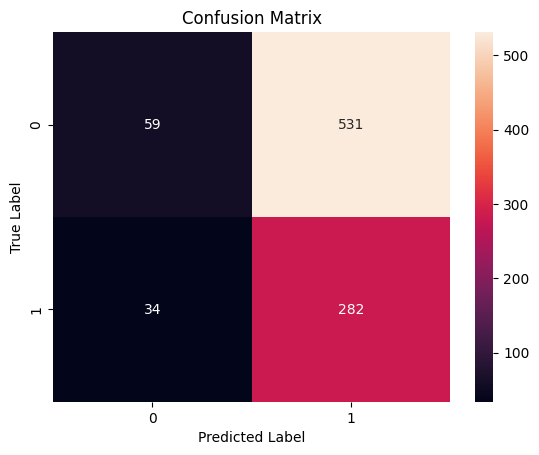


ACTUAL = PRED = 1



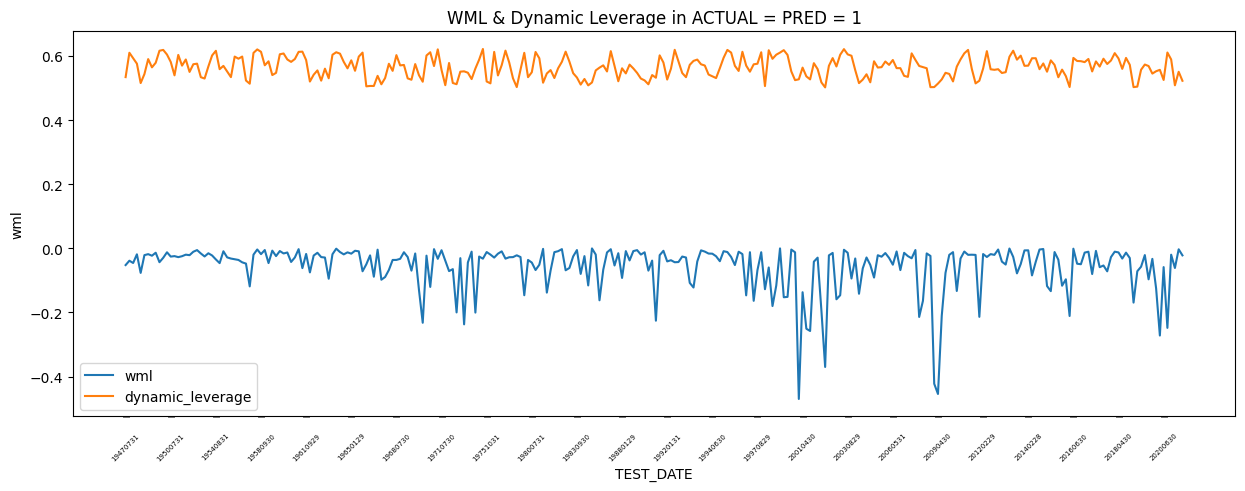

count      mean       var       std       min        1%       25%  \
wml  282.0 -0.056313  0.005171  0.071909 -0.469903 -0.379989 -0.067781   

          50%       75%       99%       max  
wml -0.028581 -0.014757 -0.000872 -0.000132

count      mean       var       std       min        1%  \
dynamic_leverage  282.0  0.564798  0.001064  0.032624  0.502231  0.503163   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.538596  0.565492  0.590282  0.620794  0.622142


--------------------------------------------------------------------------------


ACTUAL = PRED = 0



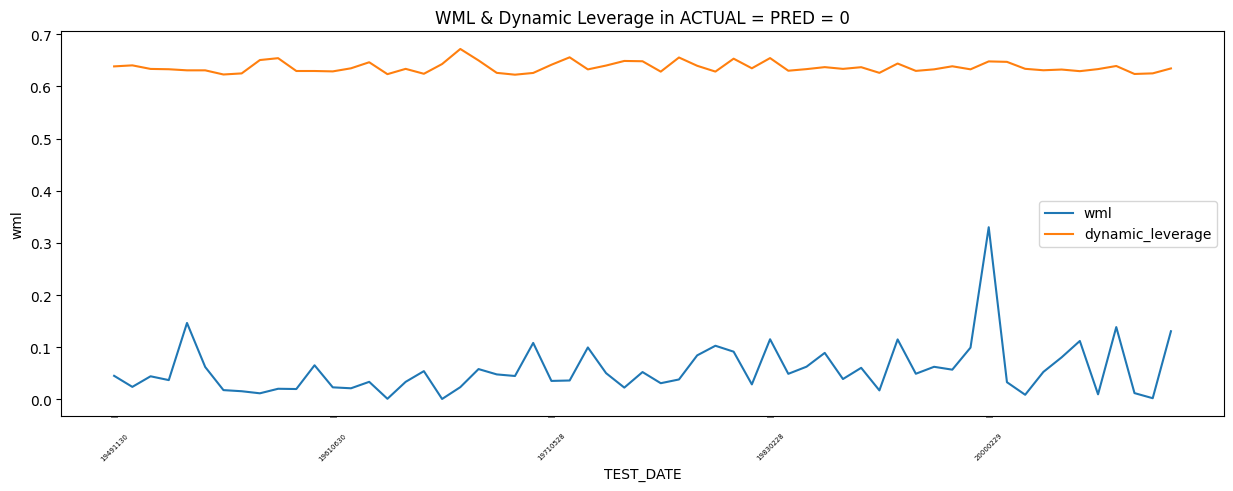

count      mean       var      std       min        1%       25%  \
wml   59.0  0.057115  0.002647  0.05145  0.000996  0.001205  0.023476   

          50%       75%       99%       max  
wml  0.045364  0.073164  0.223736  0.330163

count      mean       var       std       min        1%  \
dynamic_leverage   59.0  0.636674  0.000107  0.010322  0.622538  0.622754   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.629598  0.633678  0.642264  0.662545  0.671829


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



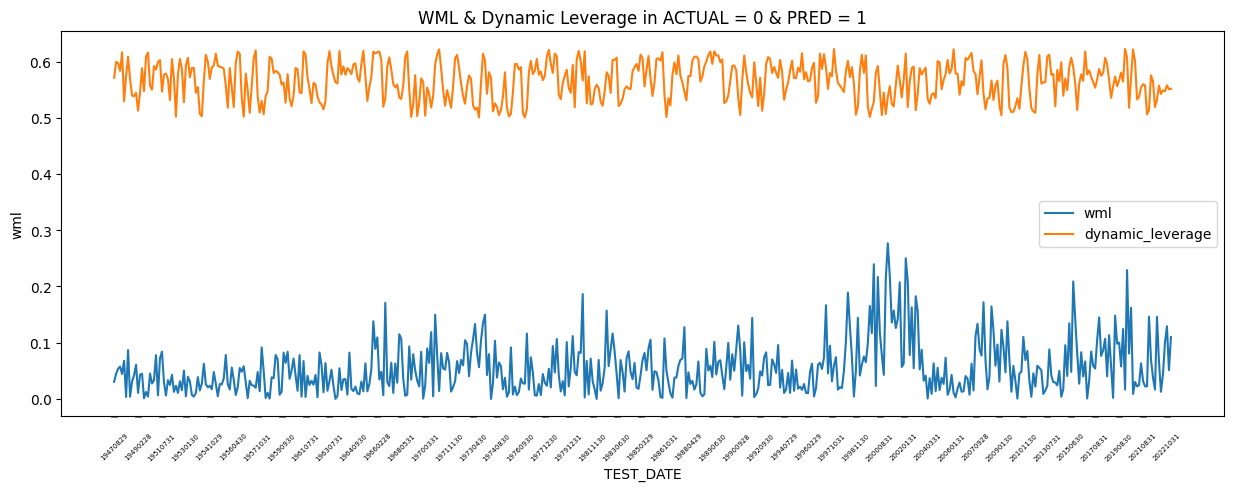

count      mean       var       std       min        1%      25%  \
wml  531.0  0.055043  0.002145  0.046315  0.000007  0.000663  0.02098   

         50%       75%       99%       max  
wml  0.04498  0.076866  0.216024  0.276912

count      mean       var       std       min        1%  \
dynamic_leverage  531.0  0.566649  0.001056  0.032492  0.500567  0.501964   

                       25%       50%      75%       99%       max  
dynamic_leverage  0.541056  0.570256  0.59224  0.620498  0.622353


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



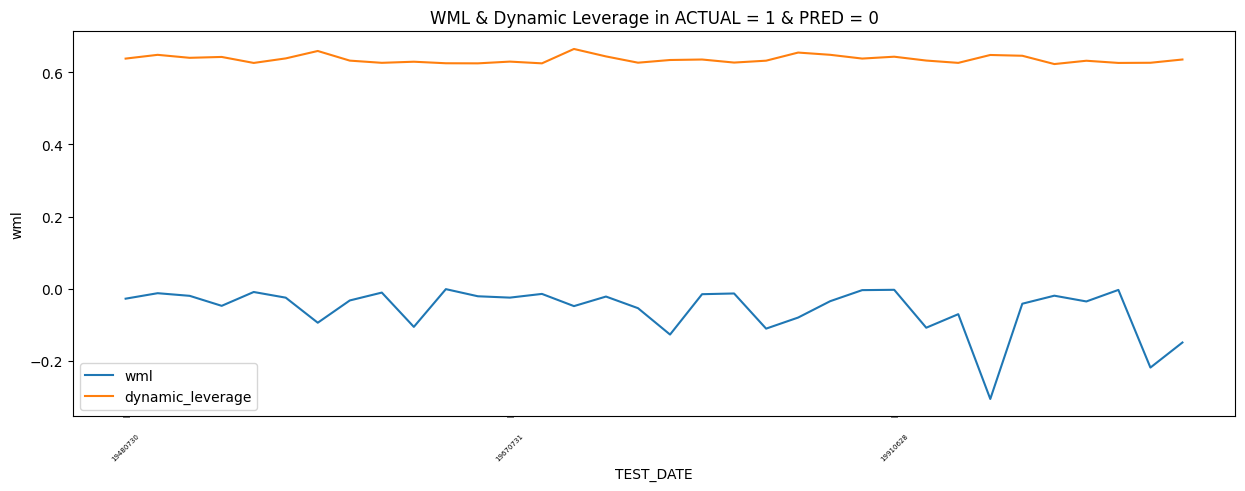

count      mean       var       std      min       1%       25%  \
wml   34.0 -0.056297  0.004407  0.066385 -0.30599 -0.27725 -0.077777   

          50%       75%       99%      max  
wml -0.030209 -0.014713 -0.001894 -0.00129

count      mean       var       std       min        1%  \
dynamic_leverage   34.0  0.636477  0.000115  0.010725  0.623164  0.623815   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.626802  0.633656  0.643396  0.663187  0.665033

In [168]:
plot_predict_result(Fixed_GRP_Result)


Top 5 dyn_mom



TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
20000229           19800229        20000131  0.330163          0.201485   
20020228           19820226        20020131  0.250175          0.116362   
20200331           20000331        20200228  0.229130          0.099972   
20000630           19800630        20000531  0.216883          0.080806   
20120531           19920529        20120430  0.138757          0.079350   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  \
TEST_DATE                                                                     
20000229           0.648000       0.610260               0                0   
20020228           0.614228       0.465120               0                1   
20200331           0.607379       0.436309               0                1   
20000630           0.592082       0.372577               0                1   
20120531           0.639194       0.571866               0                0   

           cum_return  
TEST_DATE              
20000229    53.365510  
20020228    61.524988  
20200331   125.264242  
20000630    46.961056  
20120531    83.860540


Bottom 5 dyn_mom



TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
20090831           19890831        20090731 -0.305990         -0.187219   
20210226           20010228        20210129 -0.218901         -0.113456   
20201130           20001130        20201030 -0.248070         -0.112063   
20210331           20010330        20210226 -0.149329         -0.083214   
20000331           19800331        20000229 -0.152528         -0.073685   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  \
TEST_DATE                                                                     
20090831           0.648362       0.611848               1                0   
20210226           0.626749       0.518297               1                0   
20201130           0.611053       0.451741               1                1   
20210331           0.635816       0.557252               1                0   
20000331           0.618477       0.483090               1                1   

           cum_return  
TEST_DATE              
20090831    64.594825  
20210226   104.390909  
20201130   117.278681  
20210331    95.620932  
20000331    49.359600

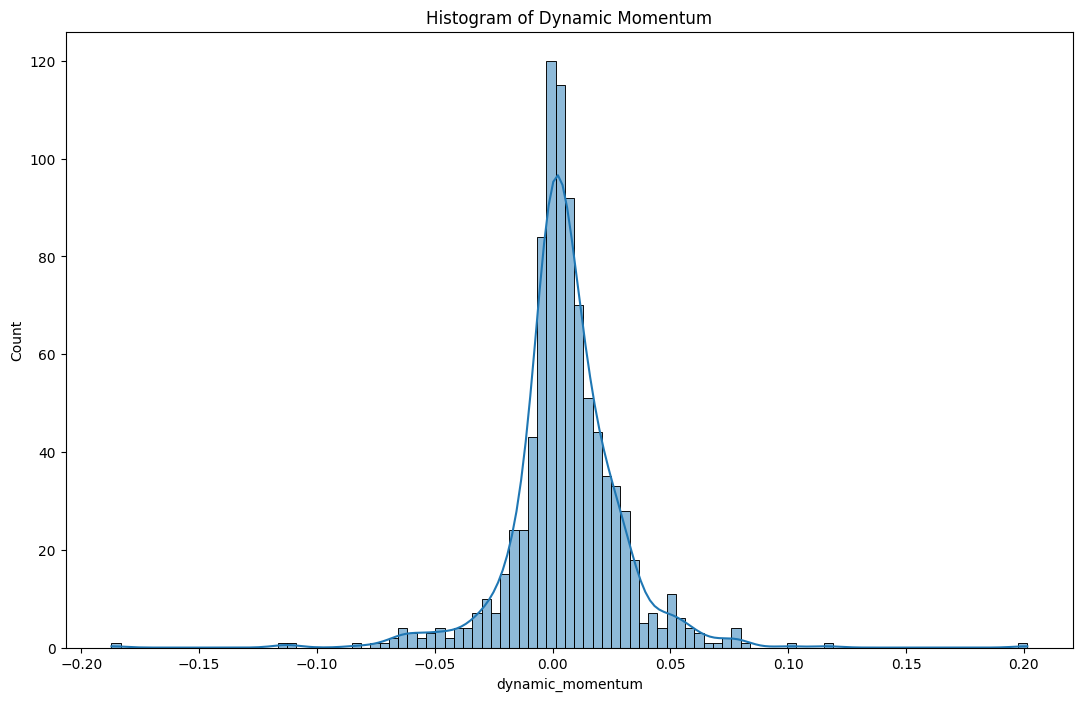

count      mean       var       std       min        1%  \
dynamic_momentum  906.0  0.005555  0.000562  0.023708 -0.187219 -0.062423   

                     25%       50%       75%       99%       max  
dynamic_momentum -0.0036  0.003503  0.015485  0.071965  0.201485

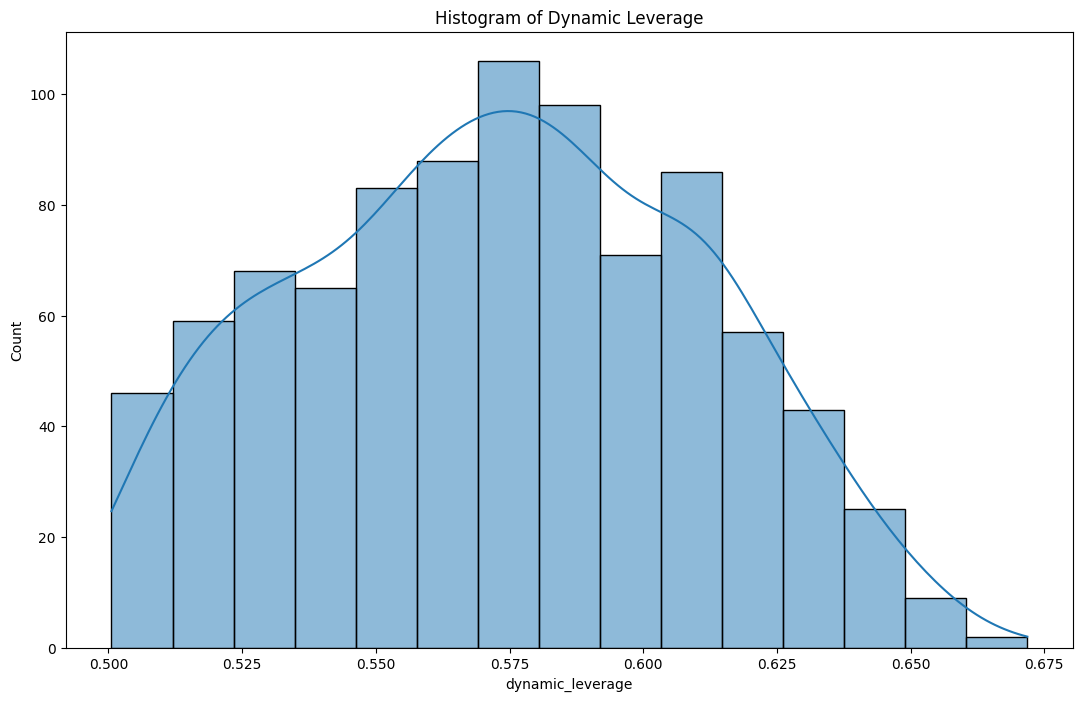

count      mean      var       std       min        1%  \
dynamic_leverage  906.0  0.573253  0.00142  0.037684  0.500567  0.502684   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.544293  0.573622  0.602776  0.650557  0.671829

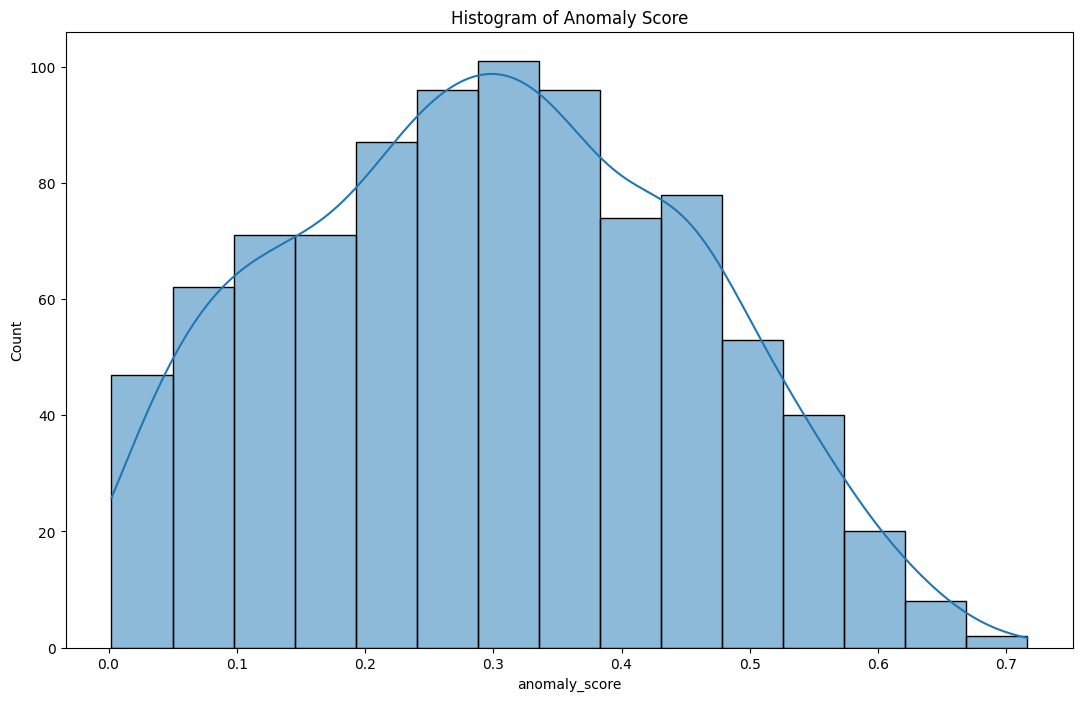

count      mean       var       std       min        1%  \
anomaly_score  906.0  0.296909  0.023976  0.154843  0.002267  0.010736   

                    25%       50%       75%      99%       max  
anomaly_score  0.177637  0.296645  0.417045  0.62149  0.716471

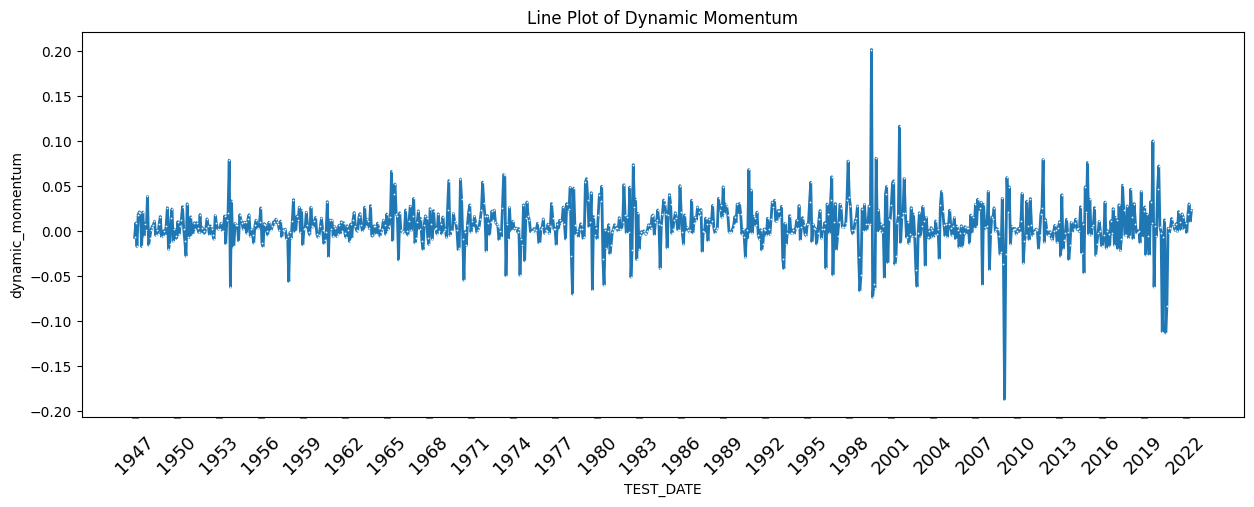

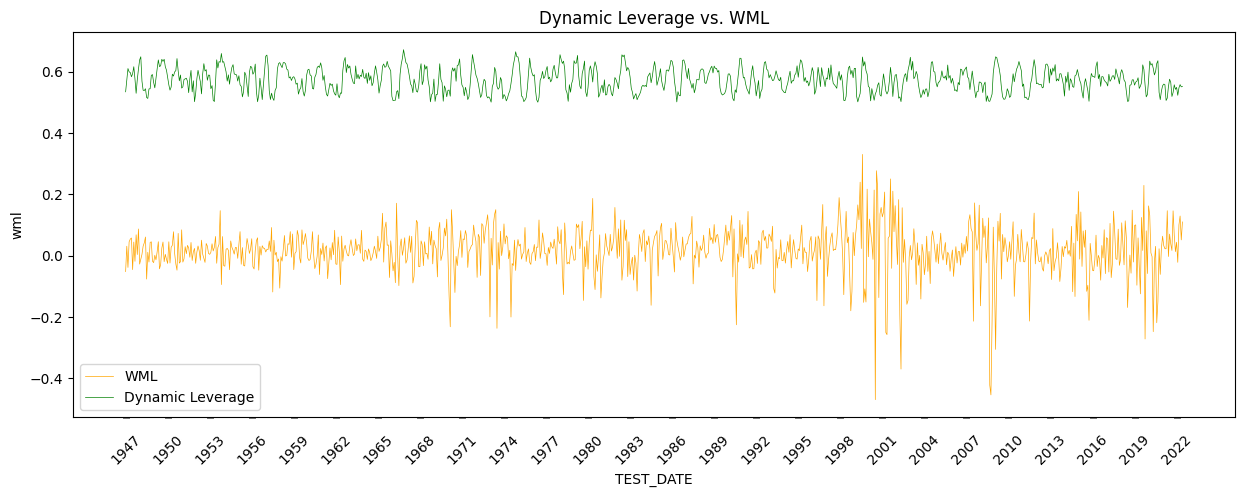

In [169]:
plot_dynamic_momentum(Fixed_GRP_Result)

## SRP

In [179]:
SRP_Param={'n_components':1,
           'density':'auto',
           'eps':0.01,
           'dense_output':True,
           'random_state':42}
SRP_MODEL = SparseRandomProjection(**SRP_Param)

In [180]:
Fixed_SRP_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=SRP_MODEL,
                                  thr=0.50)

  0%|          | 0/906 [00:00<?, ?it/s]

In [181]:
Fixed_SRP_Result.head(10)

TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
19470731           19270730        19470630 -0.052114         -0.002971   
19470829           19270831        19470731  0.030634          0.006280   
19470930           19270930        19470829 -0.038537         -0.016333   
19471031           19271031        19470930  0.044931          0.010103   
19471129           19271130        19471031  0.053920          0.011444   
19471231           19271231        19471129  0.057494          0.007067   
19480131           19280131        19471231 -0.045630         -0.010312   
19480228           19280229        19480131  0.044267          0.008187   
19480331           19280331        19480228 -0.018584         -0.003139   
19480430           19280430        19480331  0.067995          0.001107   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  
TEST_DATE                                                                    
19470731           0.514247       0.057002               1                1  
19470829           0.551072       0.205004               0                1  
19470930           0.604397       0.423820               1                1  
19471031           0.555976       0.224845               0                1  
19471129           0.552861       0.212237               0                1  
19471231           0.530692       0.122923               0                1  
19480131           0.556258       0.225991               1                1  
19480228           0.546104       0.184942               0                1  
19480331           0.542131       0.168924               1                1  
19480430           0.504072       0.016287               0                1

In [182]:
Fixed_SRP_Result.loc[Fixed_SRP_Result['static_leverage']==0]

TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
19491130           19291127        19491031  0.045364          0.024304   
19580930           19380930        19580829 -0.017975         -0.010465   
19630329           19430331        19630228  0.033848          0.020478   
19701130           19501130        19701030  0.078579          0.043437   
19710331           19510331        19710226 -0.032640         -0.018200   
19710430           19510430        19710331  0.014041          0.008095   
19750430           19550429        19750331  0.050461          0.025555   
19750530           19550531        19750430 -0.048373         -0.025038   
20030731           19830729        20030630  0.033134          0.018190   
20090731           19890731        20090630 -0.070753         -0.046171   
20090831           19890831        20090731 -0.305990         -0.194831   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  
TEST_DATE                                                                    
19491130           0.630825       0.535759               0                0  
19580930           0.641574       0.582204               1                0  
19630329           0.646795       0.604983               0                0  
19701130           0.634779       0.552773               0                0  
19710331           0.635896       0.557597               1                0  
19710430           0.640267       0.576524               0                0  
19750430           0.623968       0.506425               0                0  
19750530           0.626591       0.517618               1                0  
20030731           0.633902       0.548995               0                0  
20090731           0.657589       0.652571               1                0  
20090831           0.654012       0.636723               1                0

In [183]:
Fixed_SRP_Result.loc[Fixed_SRP_Result['static_leverage']==1]

TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
19470731           19270730        19470630 -0.052114         -0.002971   
19470829           19270831        19470731  0.030634          0.006280   
19470930           19270930        19470829 -0.038537         -0.016333   
19471031           19271031        19470930  0.044931          0.010103   
19471129           19271130        19471031  0.053920          0.011444   
...                     ...             ...       ...               ...   
20220831           20020830        20220729 -0.021856         -0.004640   
20220930           20020930        20220831  0.099930          0.009792   
20221031           20021031        20220930  0.129322          0.028582   
20221130           20021129        20221031  0.051291          0.011251   
20221230           20021231        20221130  0.109899          0.018907   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  
TEST_DATE                                                                    
19470731           0.514247       0.057002               1                1  
19470829           0.551072       0.205004               0                1  
19470930           0.604397       0.423820               1                1  
19471031           0.555976       0.224845               0                1  
19471129           0.552861       0.212237               0                1  
...                     ...            ...             ...              ...  
20220831           0.552875       0.212294               1                1  
20220930           0.524476       0.097984               0                1  
20221031           0.555030       0.221016               0                1  
20221130           0.554619       0.219350               0                1  
20221230           0.542904       0.172040               0                1  

[895 rows x 8 columns]

ORG Sharpe Ratio : 0.7293406994683723
ML Sharpe Ratio : 0.4044550212428696


최근 누적 수익률

  2022년-12월 -> 3.51
  2022년-11월 -> 3.43
  2022년-10월 -> 3.38
  2022년-09월 -> 3.25
  2022년-08월 -> 3.21

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 5.19
  2등 : 2009년-01월 -> 4.97
  3등 : 2008년-11월 -> 4.94
  4등 : 2008년-10월 -> 4.94
  5등 : 2008년-12월 -> 4.91
  6등 : 2008년-09월 -> 4.91
  7등 : 2008년-06월 -> 4.86
  8등 : 2008년-07월 -> 4.85
  9등 : 2008년-08월 -> 4.84
  10등 : 2008년-05월 -> 4.80



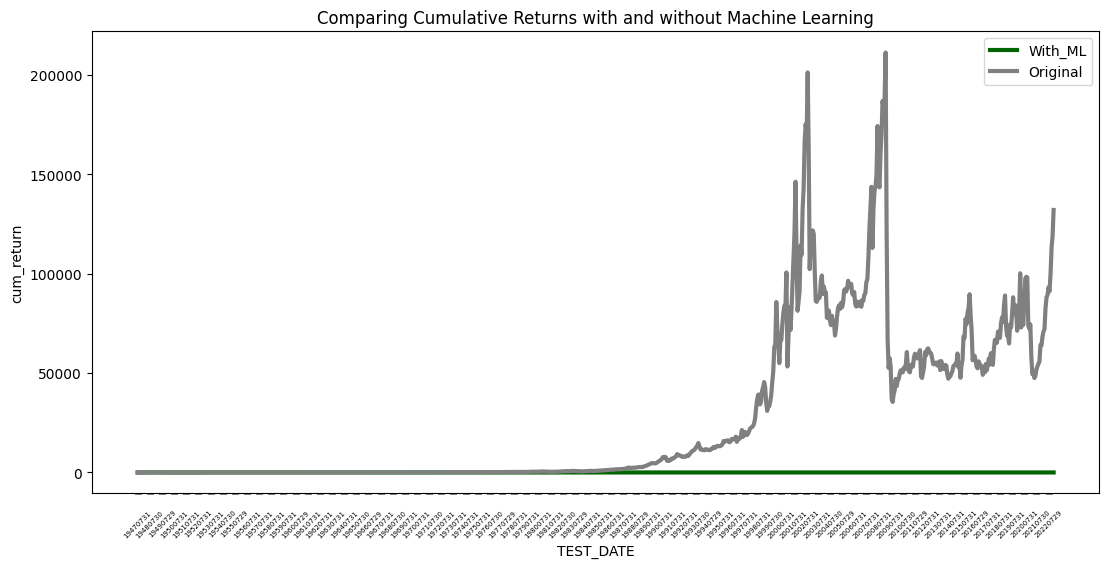

In [184]:
cum_return_sharpe_ratio(data=Fixed_SRP_Result,
                        dynamic=True)


Performance results of the model

              precision    recall  f1-score   support

           0       0.55      0.01      0.02       590
           1       0.35      0.98      0.51       316

    accuracy                           0.35       906
   macro avg       0.45      0.50      0.27       906
weighted avg       0.48      0.35      0.19       906


accuracy : 0.3498896247240618

precision : 0.3474860335195531

recall : 0.9841772151898734

F1-Score : 0.5136251032204789



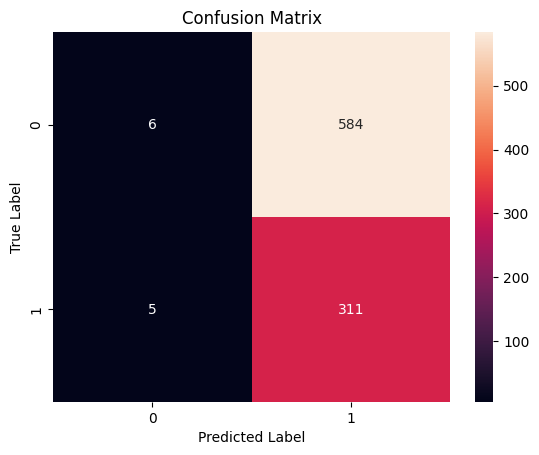


ACTUAL = PRED = 1



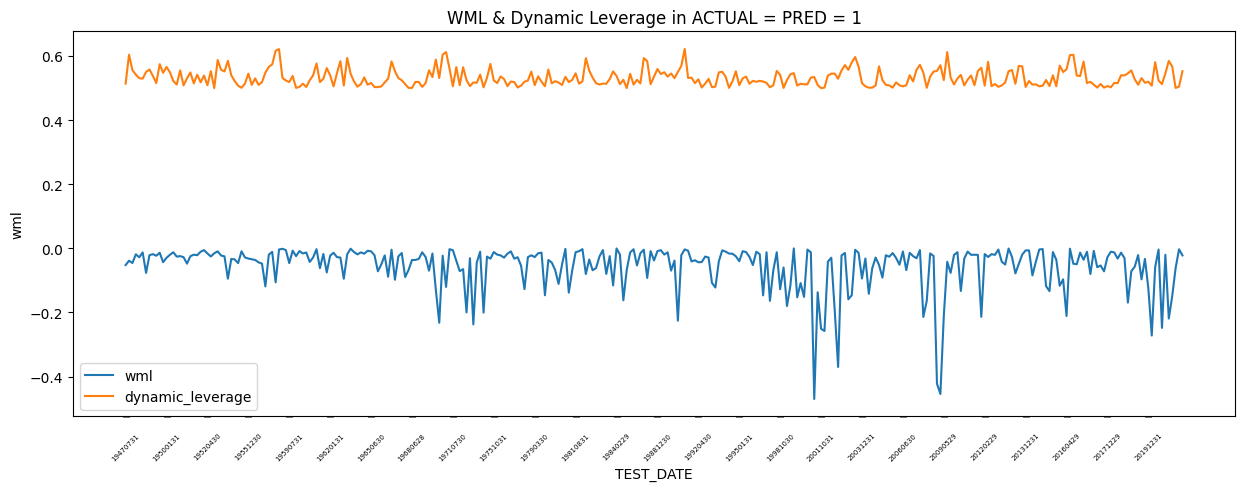

count      mean       var       std       min        1%       25%  \
wml  311.0 -0.055687  0.004947  0.070338 -0.469903 -0.360234 -0.067835   

          50%       75%       99%       max  
wml -0.028471 -0.014359 -0.000969 -0.000132

count      mean       var       std       min        1%  \
dynamic_leverage  311.0  0.532884  0.000724  0.026908  0.500047  0.500632   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.511474  0.525305  0.549118  0.612535  0.622289


--------------------------------------------------------------------------------


ACTUAL = PRED = 0



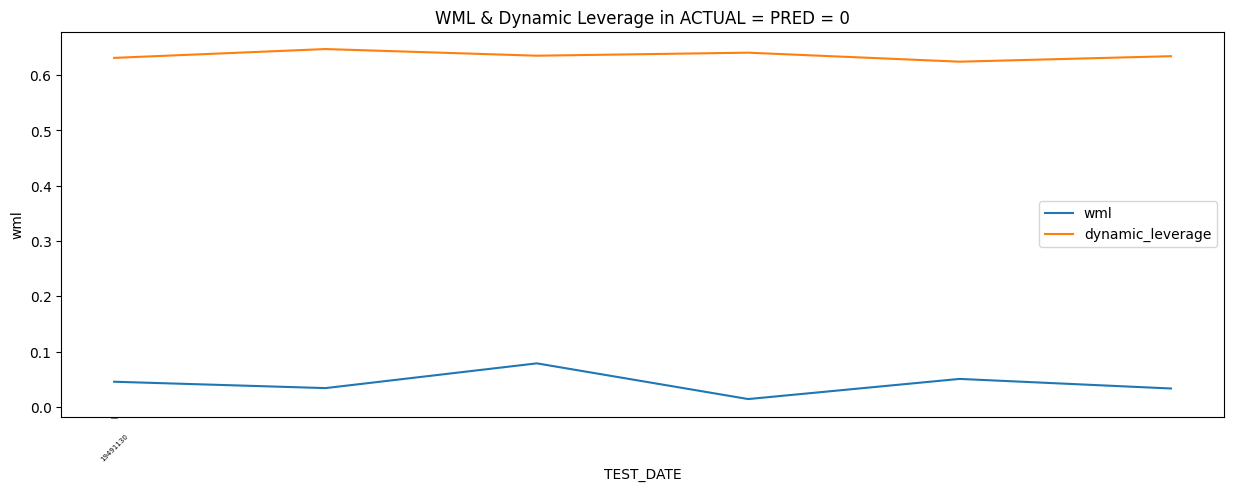

count      mean       var      std       min        1%       25%  \
wml    6.0  0.042571  0.000469  0.02166  0.014041  0.014996  0.033312   

          50%       75%       99%       max  
wml  0.039606  0.049186  0.077174  0.078579

count     mean       var       std       min        1%  \
dynamic_leverage    6.0  0.63509  0.000061  0.007839  0.623968  0.624311   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.631595  0.634341  0.638895  0.646469  0.646795


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



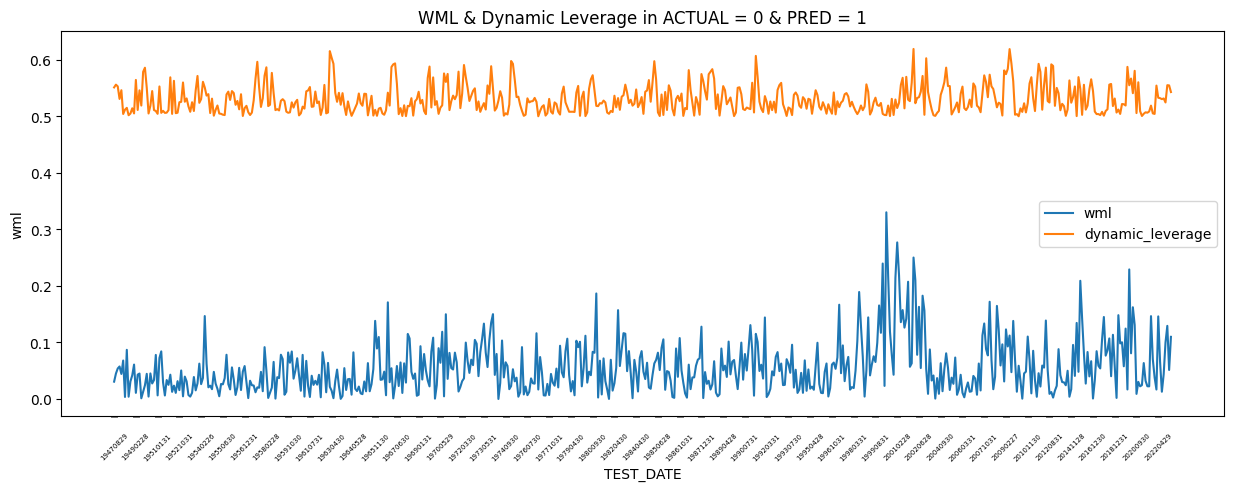

count     mean       var       std       min        1%       25%  \
wml  584.0  0.05538  0.002208  0.046991  0.000007  0.000685  0.021416   

         50%       75%       99%       max  
wml  0.04509  0.077301  0.217245  0.330163

count      mean       var       std       min        1%  \
dynamic_leverage  584.0  0.529964  0.000611  0.024728  0.500059  0.500436   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.510749  0.524256  0.543651  0.598599  0.619082


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



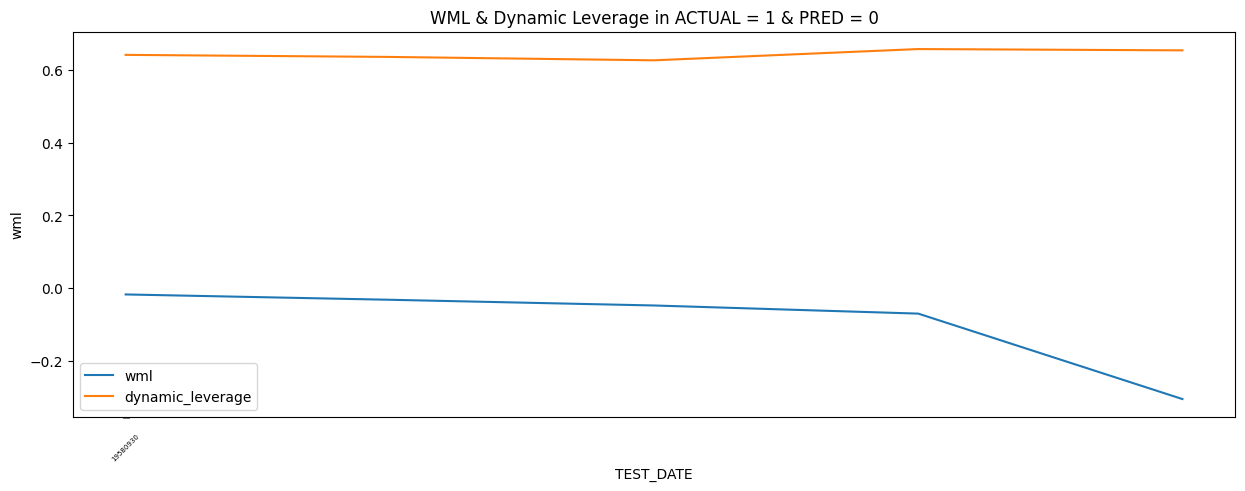

count      mean       var       std      min       1%       25%  \
wml    5.0 -0.095146  0.014275  0.119478 -0.30599 -0.29658 -0.070753   

          50%      75%       99%       max  
wml -0.048373 -0.03264 -0.018562 -0.017975

count      mean       var       std       min        1%  \
dynamic_leverage    5.0  0.643133  0.000164  0.012804  0.626591  0.626963   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.635896  0.641574  0.654012  0.657446  0.657589

In [185]:
plot_predict_result(Fixed_SRP_Result)


Top 5 dyn_mom



TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
20020228           19820226        20020131  0.250175          0.121498   
20091030           19891031        20090930  0.112171          0.054371   
20020930           19820930        20020830  0.182647          0.052470   
20080229           19880229        20080131  0.171940          0.050967   
20200331           20000331        20200228  0.229130          0.050504   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  \
TEST_DATE                                                                     
20020228           0.619082       0.485652               0                1   
20091030           0.618861       0.484718               0                1   
20020930           0.571328       0.287273               0                1   
20080229           0.573569       0.296426               0                1   
20200331           0.554882       0.220416               0                1   

           cum_return  
TEST_DATE              
20020228     3.983066  
20091030     2.921065  
20020930     4.507045  
20080229     4.664391  
20200331     3.284232


Bottom 5 dyn_mom



TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
20090831           19890831        20090731 -0.305990         -0.194831   
20090430           19890428        20090331 -0.454349         -0.131285   
20090331           19890331        20090227 -0.422400         -0.091234   
20210226           20010228        20210129 -0.218901         -0.075233   
20010131           19810130        20001229 -0.469903         -0.065182   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  \
TEST_DATE                                                                     
20090831           0.654012       0.636723               1                0   
20090430           0.571740       0.288953               1                1   
20090331           0.553788       0.215988               1                1   
20210226           0.585086       0.343687               1                1   
20010131           0.534623       0.138714               1                1   

           cum_return  
TEST_DATE              
20090831     2.791231  
20090430     3.889463  
20090331     4.628388  
20210226     3.174654  
20010131     2.664280

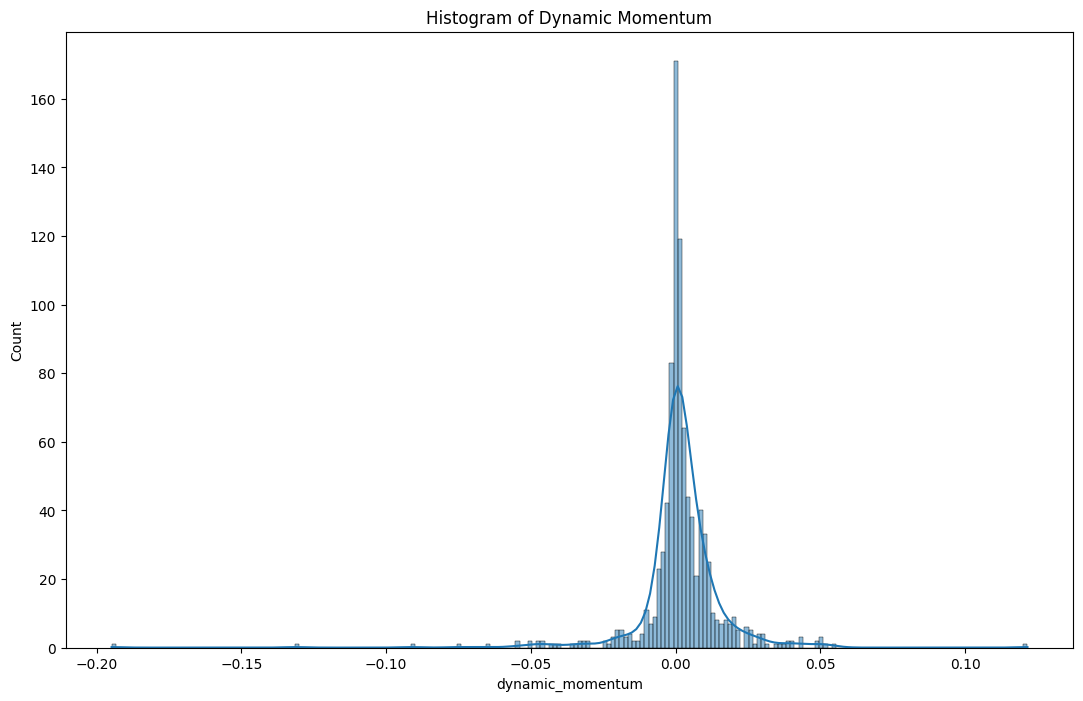

count      mean       var       std       min        1%  \
dynamic_momentum  906.0  0.001784  0.000234  0.015284 -0.194831 -0.047478   

                       25%       50%       75%       99%       max  
dynamic_momentum -0.001084  0.000874  0.005879  0.043035  0.121498

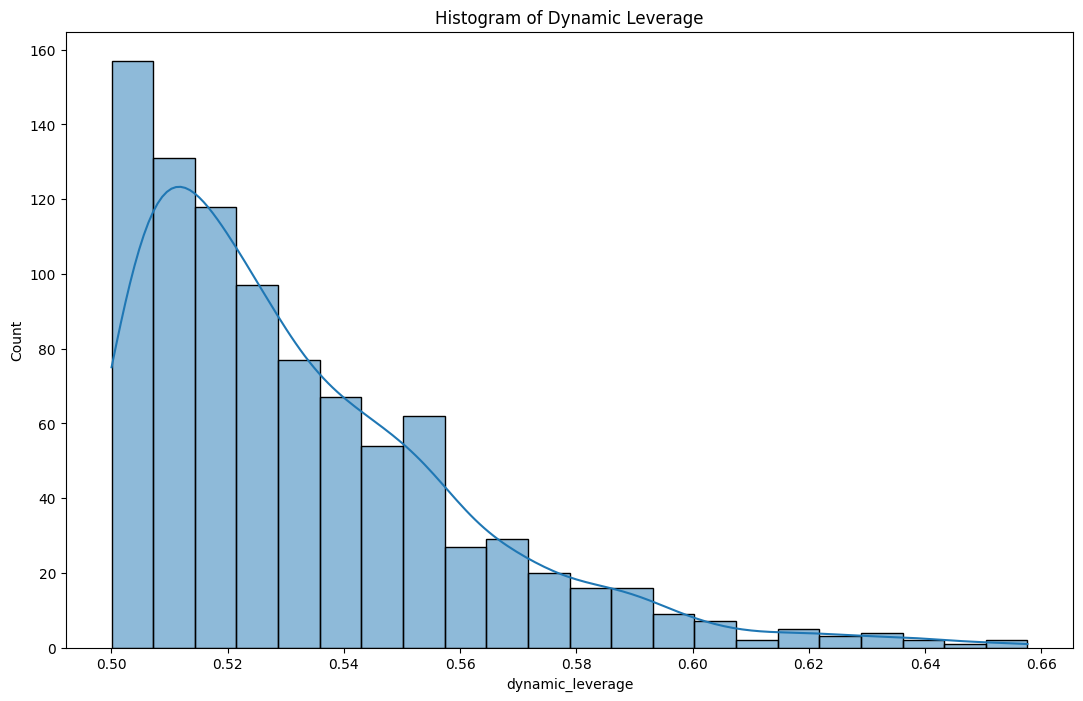

count      mean       var      std       min        1%  \
dynamic_leverage  906.0  0.532287  0.000785  0.02801  0.500047  0.500446   

                       25%      50%       75%       99%       max  
dynamic_leverage  0.510975  0.52484  0.546128  0.626459  0.657589

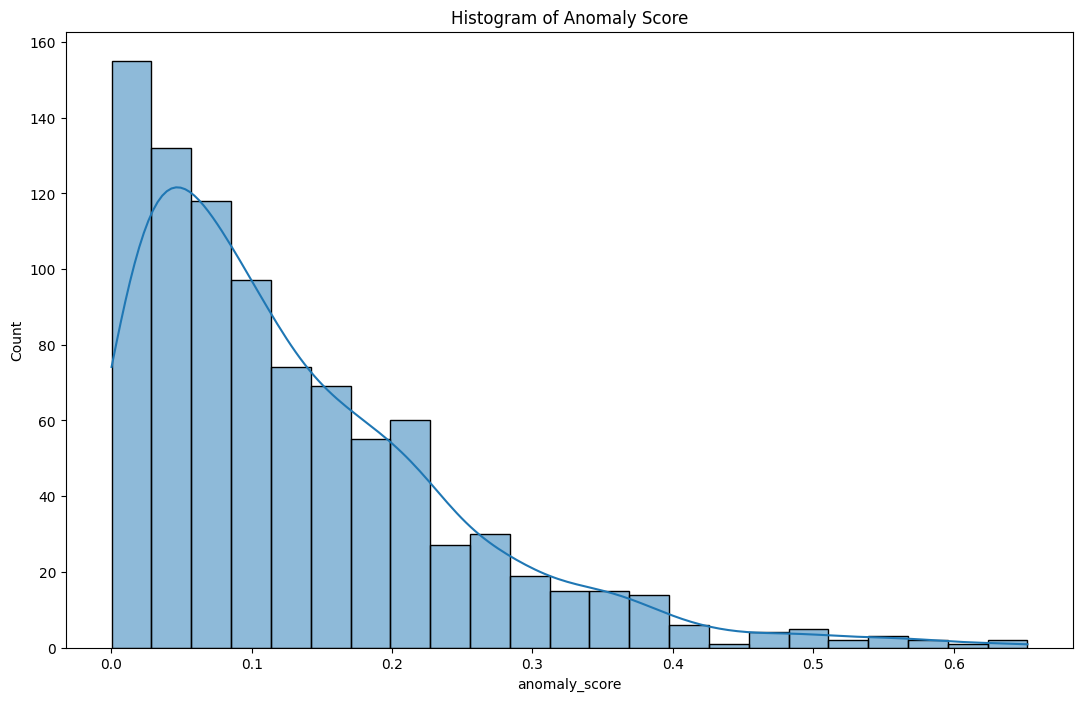

count      mean       var       std      min        1%  \
anomaly_score  906.0  0.129911  0.012931  0.113714  0.00019  0.001783   

                    25%       50%       75%       99%       max  
anomaly_score  0.043908  0.099444  0.185037  0.517058  0.652571

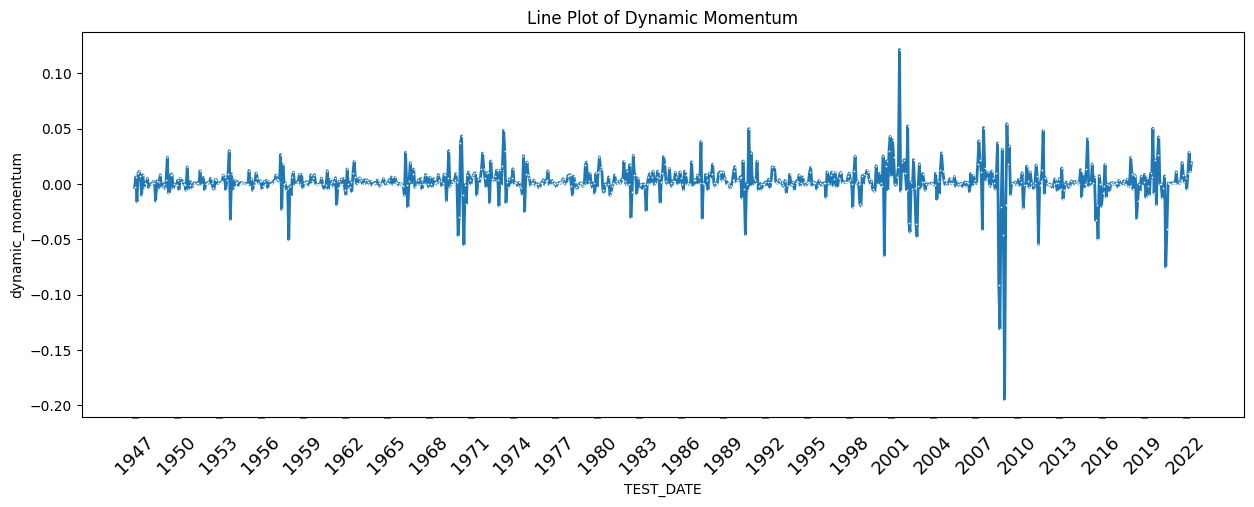

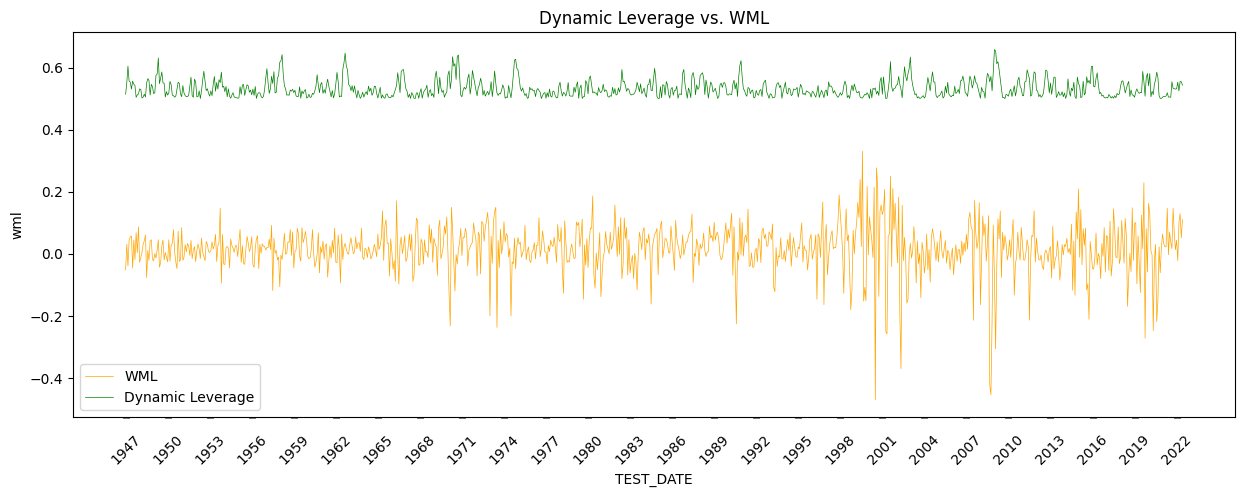

In [186]:
plot_dynamic_momentum(Fixed_SRP_Result)

## ICA

In [189]:
ICA_Param={'n_components':1,
            'algorithm':'parallel',
            'whiten':True,
            'max_iter':200,
            'random_state':42}
ICA_MODEL = FastICA(**ICA_Param)

In [190]:
Fixed_ICA_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=ICA_MODEL,
                                  thr=0.50)

  0%|          | 0/906 [00:00<?, ?it/s]

In [191]:
Fixed_ICA_Result.head(10)

TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
19470731           19270730        19470630 -0.052114         -0.019848   
19470829           19270831        19470731  0.030634          0.012903   
19470930           19270930        19470829 -0.038537         -0.020630   
19471031           19271031        19470930  0.044931          0.037878   
19471129           19271130        19471031  0.053920          0.048016   
19471231           19271231        19471129  0.057494          0.055229   
19480131           19280131        19471231 -0.045630         -0.039666   
19480228           19280229        19480131  0.044267          0.034214   
19480331           19280331        19480228 -0.018584         -0.015796   
19480430           19280430        19480331  0.067995          0.054496   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  
TEST_DATE                                                                    
19470731           0.594081       0.380860               1                1  
19470829           0.603768       0.421191               0                1  
19470930           0.630726       0.535331               1                0  
19471031           0.699102       0.843025               0                0  
19471129           0.708993       0.890499               0                0  
19471231           0.723242       0.960600               0                0  
19480131           0.704598       0.869289               1                0  
19480228           0.684150       0.772908               0                0  
19480331           0.700553       0.849931               1                0  
19480430           0.690291       0.801480               0                0

In [192]:
Fixed_ICA_Result.loc[Fixed_ICA_Result['static_leverage']==0]

TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
19470930           19270930        19470829 -0.038537         -0.020630   
19471031           19271031        19470930  0.044931          0.037878   
19471129           19271130        19471031  0.053920          0.048016   
19471231           19271231        19471129  0.057494          0.055229   
19480131           19280131        19471231 -0.045630         -0.039666   
...                     ...             ...       ...               ...   
20220831           20020830        20220729 -0.021856         -0.019317   
20220930           20020930        20220831  0.099930          0.091980   
20221031           20021031        20220930  0.129322          0.118746   
20221130           20021129        20221031  0.051291          0.045704   
20221230           20021231        20221130  0.109899          0.098499   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  
TEST_DATE                                                                    
19470930           0.630726       0.535331               1                0  
19471031           0.699102       0.843025               0                0  
19471129           0.708993       0.890499               0                0  
19471231           0.723242       0.960600               0                0  
19480131           0.704598       0.869289               1                0  
...                     ...            ...             ...              ...  
20220831           0.707618       0.883843               1                0  
20220930           0.715133       0.920447               0                0  
20221031           0.714680       0.918225               0                0  
20221130           0.709110       0.891067               0                0  
20221230           0.710181       0.896265               0                0  

[902 rows x 8 columns]

In [193]:
Fixed_ICA_Result.loc[Fixed_ICA_Result['static_leverage']==1]

TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
19470731           19270730        19470630 -0.052114         -0.019848   
19470829           19270831        19470731  0.030634          0.012903   
20090731           19890731        20090630 -0.070753         -0.014683   
20091130           19891130        20091030  0.047411          0.020180   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  
TEST_DATE                                                                    
19470731           0.594081       0.380860               1                1  
19470829           0.603768       0.421191               0                1  
20090731           0.551695       0.207523               1                1  
20091130           0.604834       0.425646               0                1

ORG Sharpe Ratio : 0.7293406994683723
ML Sharpe Ratio : 0.7645507729006024


최근 누적 수익률

  2022년-12월 -> 82553.31
  2022년-11월 -> 75150.92
  2022년-10월 -> 71866.29
  2022년-09월 -> 64238.13
  2022년-08월 -> 58827.11

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 82553.31
  2등 : 2009년-02월 -> 78015.88
  3등 : 2002년-09월 -> 76684.37
  4등 : 2022년-11월 -> 75150.92
  5등 : 2022년-10월 -> 71866.29
  6등 : 2009년-01월 -> 71211.84
  7등 : 2008년-11월 -> 71049.92
  8등 : 2008년-12월 -> 69684.98
  9등 : 2002년-07월 -> 68401.46
  10등 : 2002년-08월 -> 66554.39



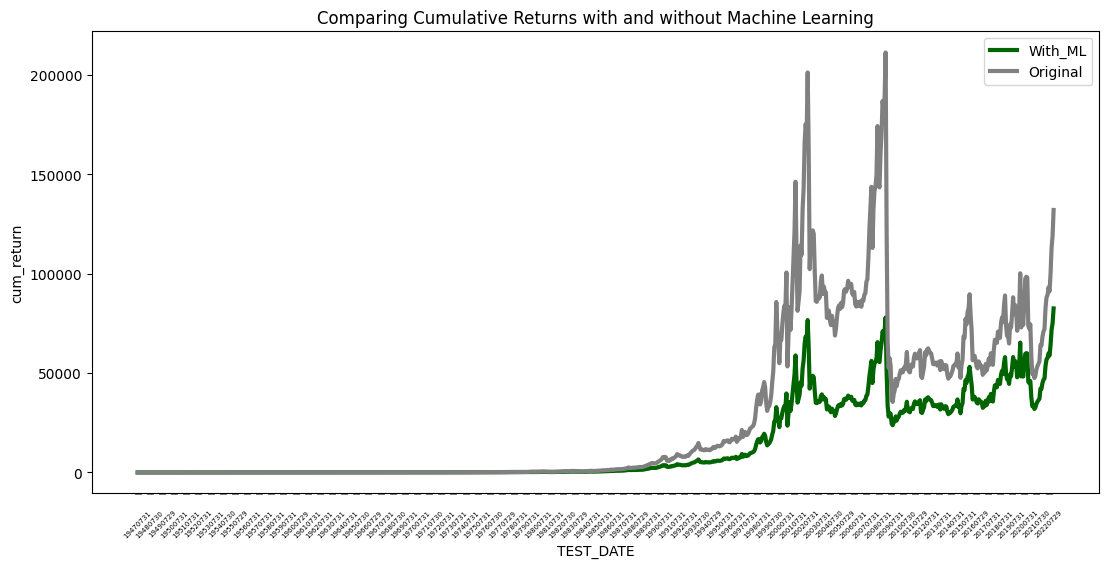

In [194]:
cum_return_sharpe_ratio(data=Fixed_ICA_Result,
                        dynamic=True)


Performance results of the model

              precision    recall  f1-score   support

           0       0.65      1.00      0.79       590
           1       0.50      0.01      0.01       316

    accuracy                           0.65       906
   macro avg       0.58      0.50      0.40       906
weighted avg       0.60      0.65      0.52       906


accuracy : 0.6512141280353201

precision : 0.5

recall : 0.006329113924050633

F1-Score : 0.012499999999999999



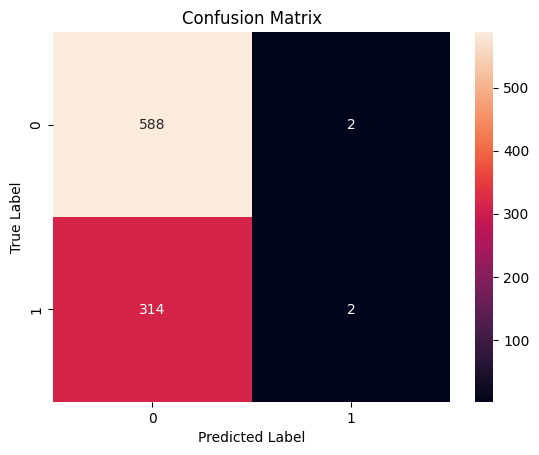


ACTUAL = PRED = 1



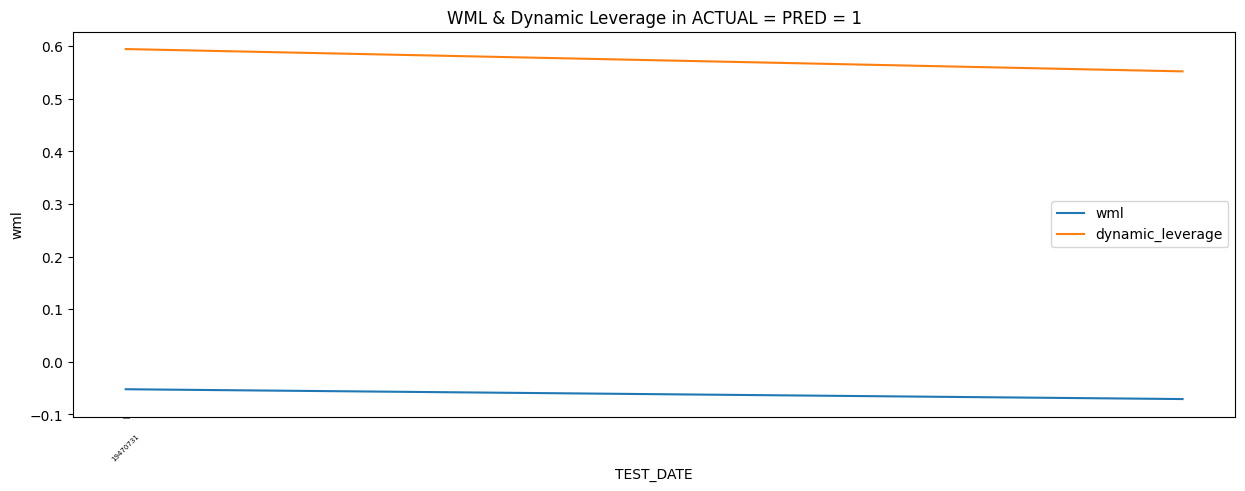

count      mean       var       std       min        1%       25%  \
wml    2.0 -0.061433  0.000174  0.013179 -0.070753 -0.070566 -0.066093   

          50%       75%       99%       max  
wml -0.061433 -0.056774 -0.052301 -0.052114

count      mean       var       std       min        1%  \
dynamic_leverage    2.0  0.572888  0.000898  0.029971  0.551695  0.552119   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.562292  0.572888  0.583484  0.593657  0.594081


--------------------------------------------------------------------------------


ACTUAL = PRED = 0



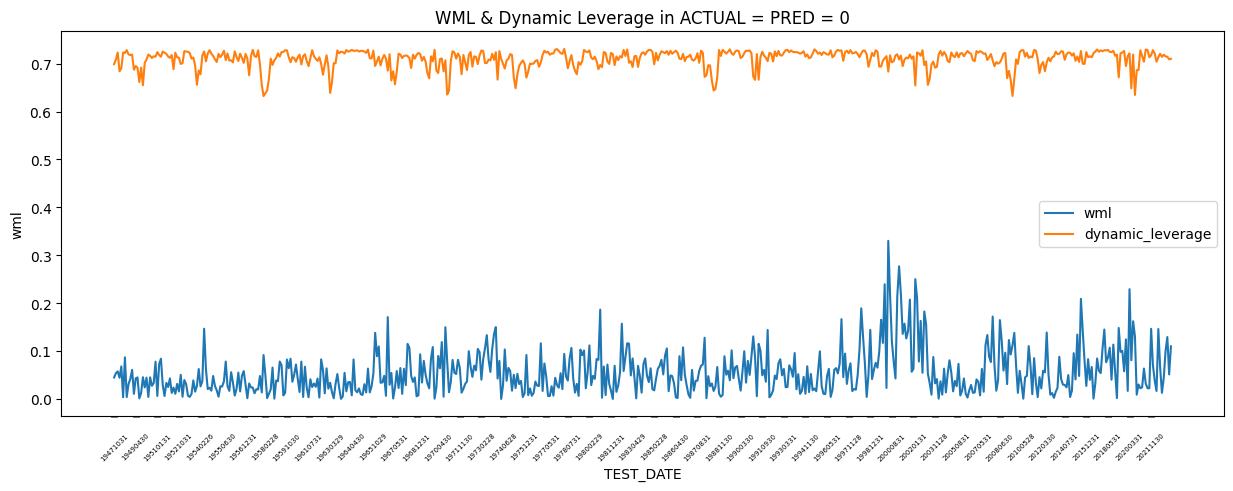

count      mean       var       std       min        1%       25%  \
wml  588.0  0.055305  0.002198  0.046879  0.000007  0.000687  0.021416   

         50%       75%      99%       max  
wml  0.04509  0.077301  0.21716  0.330163

count      mean       var       std      min        1%  \
dynamic_leverage  588.0  0.710474  0.000339  0.018408  0.63234  0.642864   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.704537  0.715532  0.723164  0.729655  0.730736


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



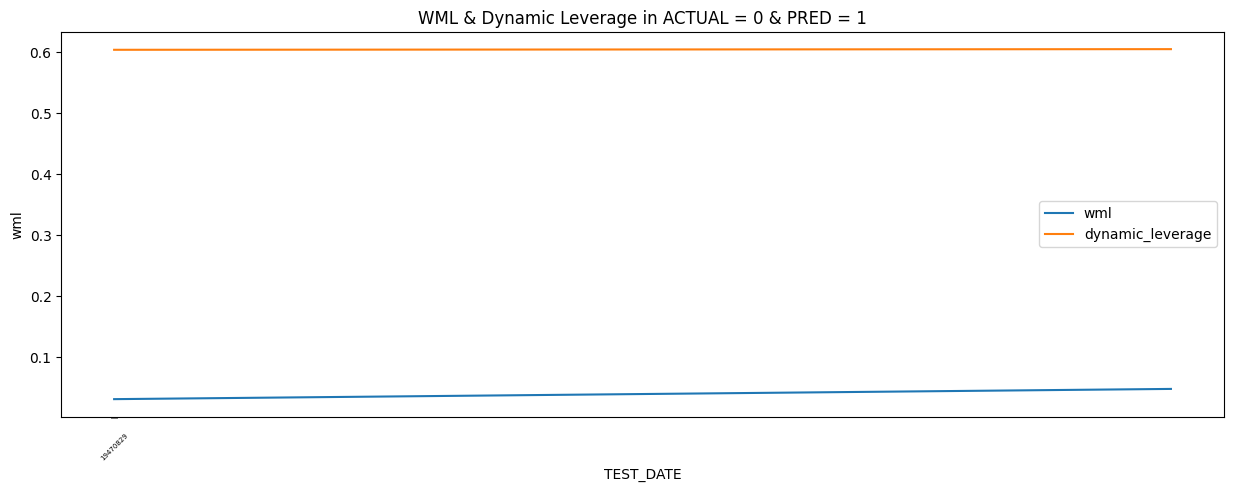

count      mean       var       std       min        1%       25%  \
wml    2.0  0.039023  0.000141  0.011863  0.030634  0.030802  0.034828   

          50%       75%       99%       max  
wml  0.039023  0.043217  0.047243  0.047411

count      mean           var       std       min        1%  \
dynamic_leverage    2.0  0.604301  5.676031e-07  0.000753  0.603768  0.603779   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.604035  0.604301  0.604567  0.604823  0.604834


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



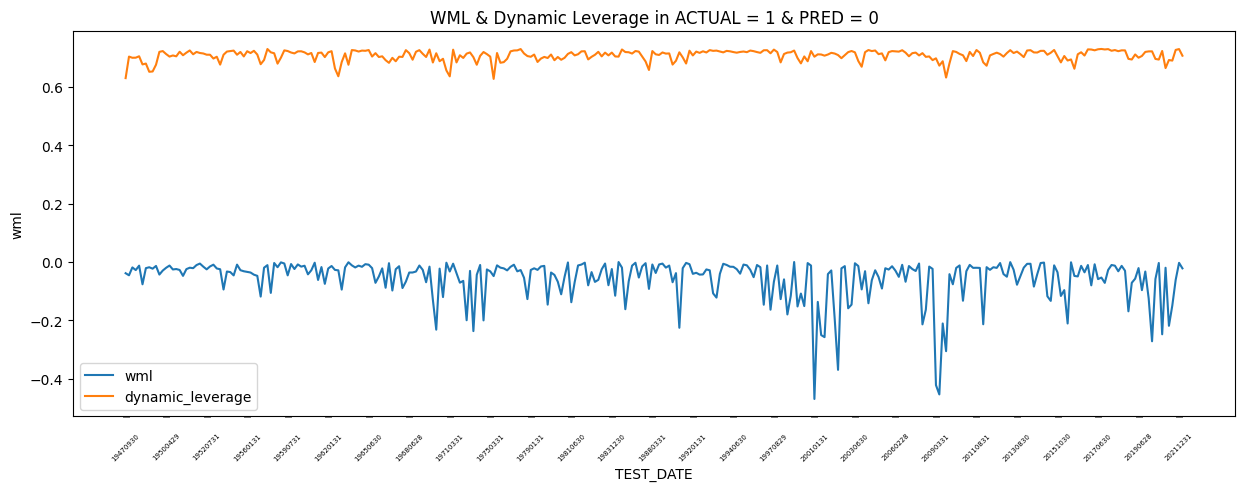

count      mean       var       std       min        1%      25%  \
wml  314.0 -0.056278  0.005106  0.071457 -0.469903 -0.361714 -0.06784   

          50%       75%       99%       max  
wml -0.028501 -0.014546 -0.000972 -0.000132

count      mean       var       std       min        1%  \
dynamic_leverage  314.0  0.708824  0.000341  0.018458  0.628114  0.636833   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.702747  0.714454  0.721927  0.730329  0.730752

In [195]:
plot_predict_result(Fixed_ICA_Result)


Top 5 dyn_mom



TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
20000229           19800229        20000131  0.330163          0.254214   
20010228           19810227        20010131  0.276912          0.246380   
20200331           20000331        20200228  0.229130          0.218144   
19991231           19791231        19991130  0.239571          0.216101   
20150731           19950731        20150630  0.209036          0.204146   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  \
TEST_DATE                                                                     
20000229           0.683513       0.769964               0                0   
20010228           0.708837       0.889741               0                0   
20200331           0.721528       0.952055               0                0   
19991231           0.711367       0.902032               0                0   
20150731           0.726435       0.976608               0                0   

             cum_return  
TEST_DATE                
20000229   32863.643175  
20010228   29353.554213  
20200331   65342.856306  
19991231   25655.171757  
20150731   41976.763956


Bottom 5 dyn_mom



TRAIN_START_DATE  TRAIN_END_DATE       wml  dynamic_momentum  \
TEST_DATE                                                                 
20010131           19810130        20001229 -0.469903         -0.407669   
20090331           19890331        20090227 -0.422400         -0.355233   
20021129           19821130        20021031 -0.370041         -0.331045   
20090430           19890428        20090331 -0.454349         -0.329231   
20200430           20000428        20200331 -0.271971         -0.260373   

           dynamic_leverage  anomaly_score  Actual_POS_WML  static_leverage  \
TEST_DATE                                                                     
20010131           0.704238       0.867560               1                0   
20090331           0.698673       0.840986               1                0   
20021129           0.709842       0.894619               1                0   
20090430           0.673624       0.724621               1                0   
20200430           0.722592       0.957357               1                0   

             cum_return  
TEST_DATE                
20010131   23550.855842  
20090331   50301.728075  
20021129   42178.709943  
20090430   33740.505219  
20200430   48329.062948

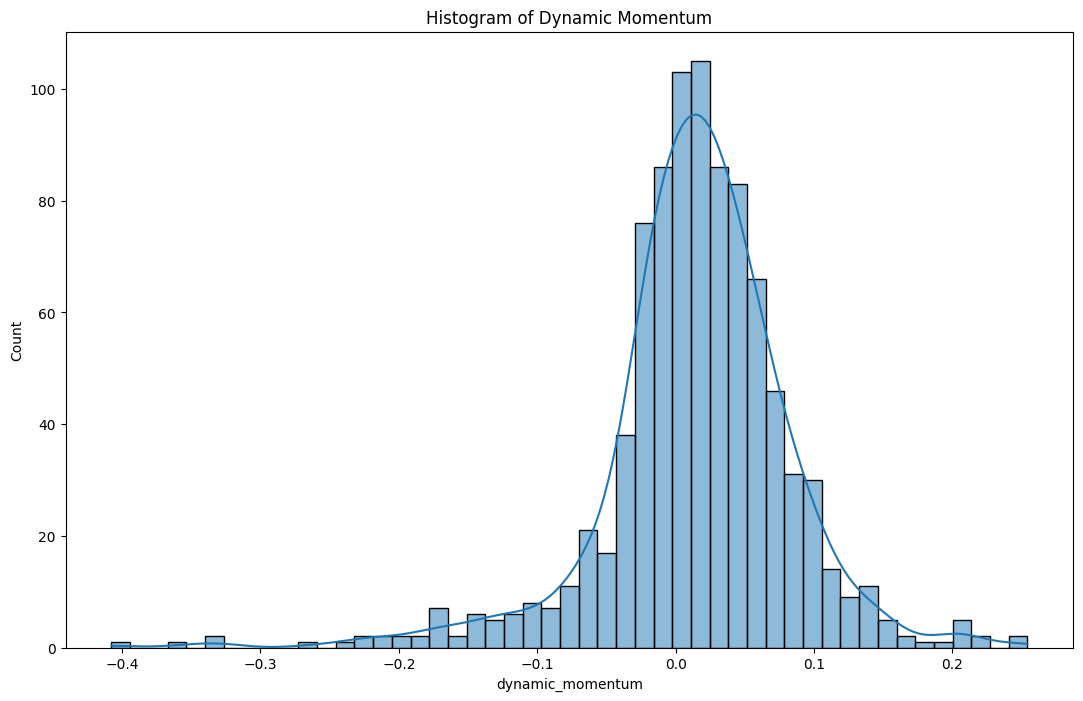

count      mean       var      std       min        1%  \
dynamic_momentum  906.0  0.015006  0.004623  0.06799 -0.407669 -0.211934   

                       25%      50%       75%       99%       max  
dynamic_momentum -0.014644  0.01683  0.051088  0.194213  0.254214

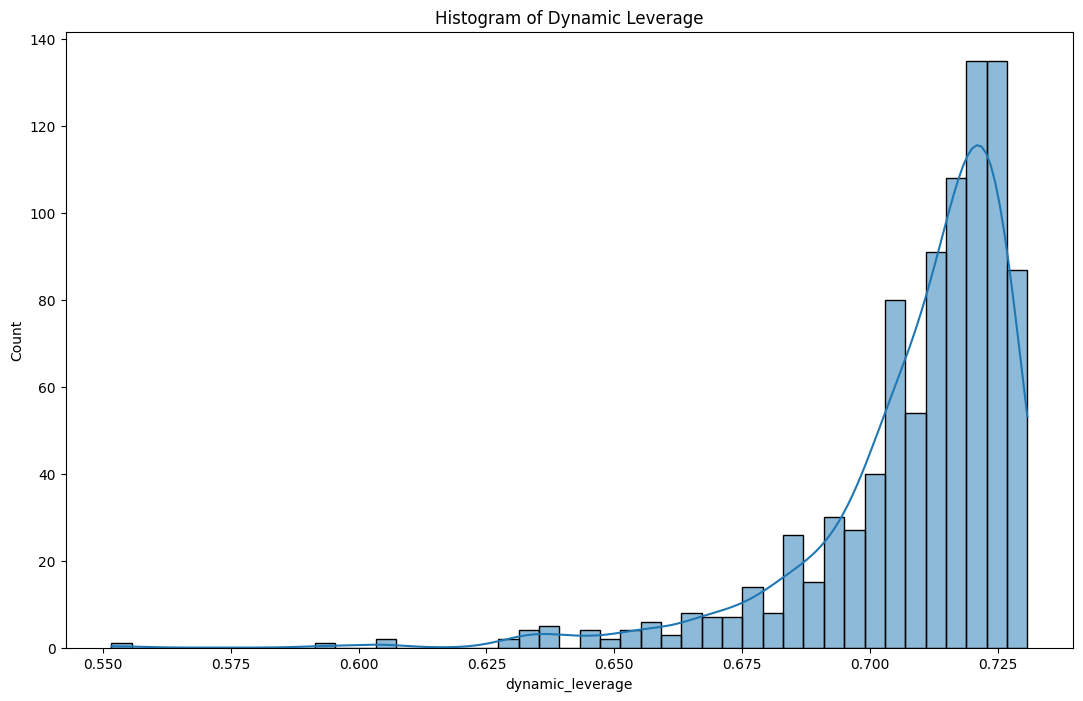

count      mean       var       std       min        1%  \
dynamic_leverage  906.0  0.709364  0.000405  0.020127  0.551695  0.634804   

                       25%       50%       75%       99%       max  
dynamic_leverage  0.703411  0.715298  0.722667  0.729736  0.730752

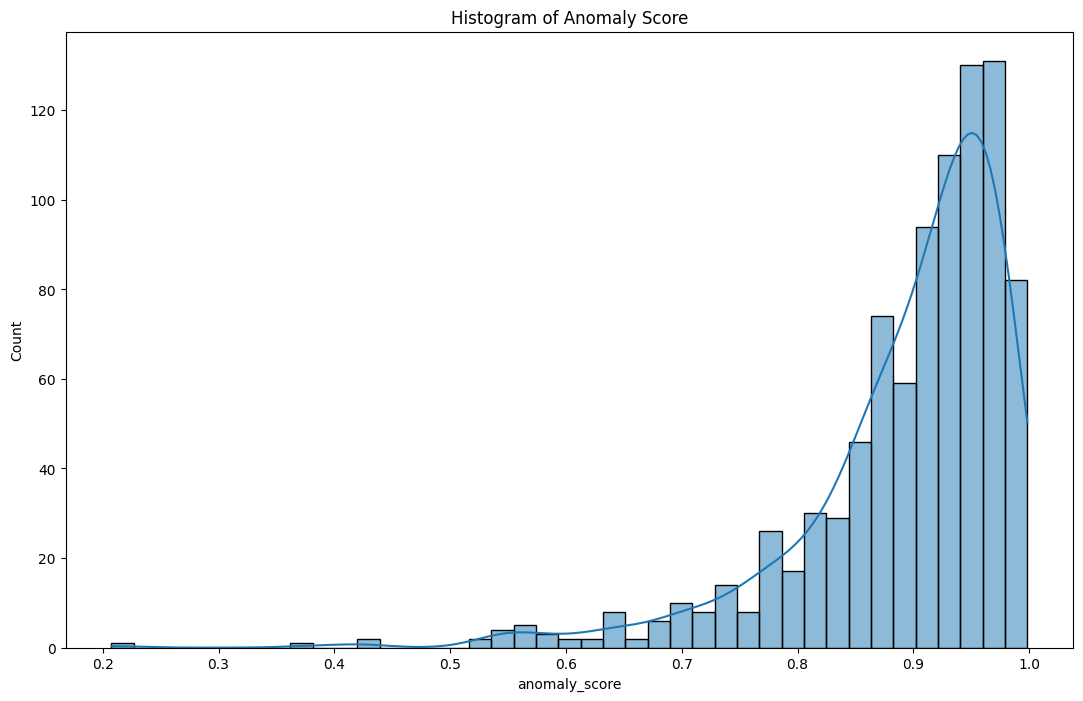

count      mean       var       std       min        1%  \
anomaly_score  906.0  0.894064  0.008854  0.094096  0.207523  0.552882   

                    25%       50%       75%       99%       max  
anomaly_score  0.863592  0.921256  0.957729  0.993286  0.998442

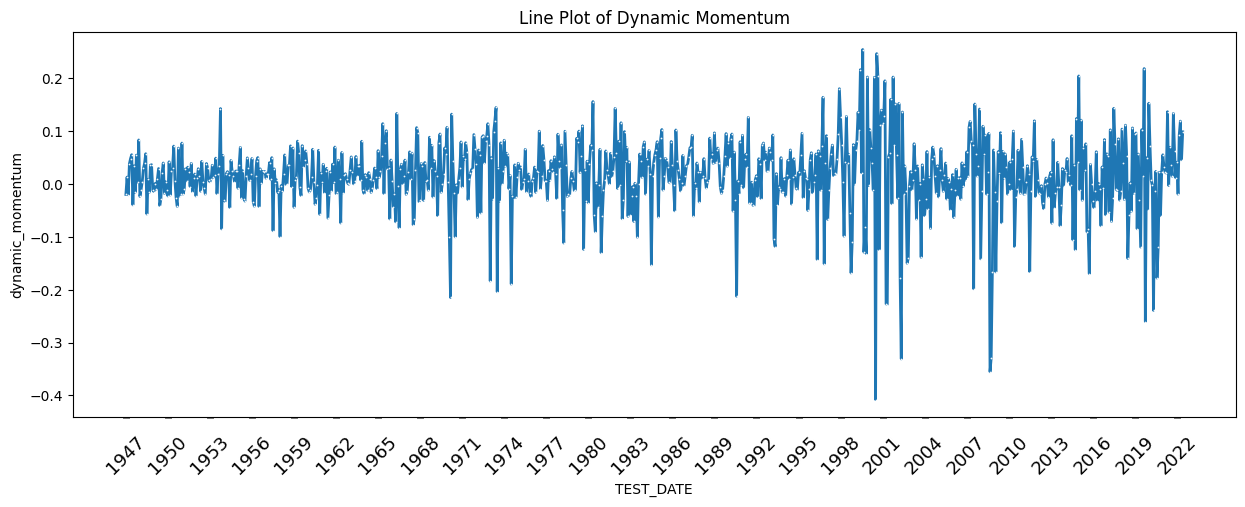

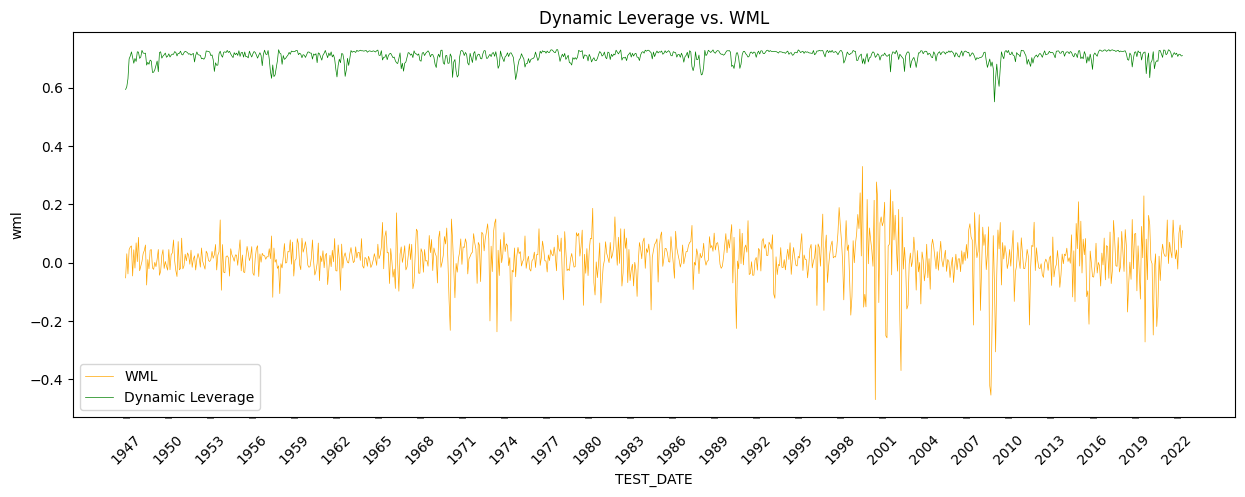

In [196]:
plot_dynamic_momentum(Fixed_ICA_Result)

# Compare

In [203]:
def compare_sharpe_ratio(list_model, list_result):
    list_Sharpe = []
    plt.figure(figsize=(13, 6))
    for model, data in zip(list_model, list_result):

      S = (data['dynamic_momentum'].mean()/data['dynamic_momentum'].std())*math.sqrt(12)
      list_Sharpe.append(S)
      C = list(data['cum_return'])[-1]
      print('{} Sharpe Ratio : {:0.4f}  최종 누적 수익률 : {}'.format(model, S, C))

      sns.lineplot(data=data, x=data.index, y='cum_return', alpha=0.7, label=model)

    CUM_WML = data[['wml']]
    CUM_WML['cum_return'] = (1 + CUM_WML.wml).cumprod() - 1

    org_S = (CUM_WML['wml'].mean()/CUM_WML['wml'].std())*math.sqrt(12)
    list_Sharpe.append(org_S)
    org_C = list(CUM_WML['cum_return'])[-1]
    print()
    print('{} Sharpe Ratio : {:0.4f}  최종 누적 수익률 : {}'.format('ORG', org_S, org_C))
    print()

    plt.title('Cum Return by Model  with Rolling Fixed Windows')
    sns.lineplot(data=CUM_WML, x=CUM_WML.index, y='cum_return', alpha=0.7, label='ORG')

    plt.xticks([CUM_WML.index[i] for i in range(0, len(CUM_WML.index), 36)],
              labels=[str(CUM_WML.index[i])[:4] for i in range(0, len(CUM_WML.index), 36)])
    plt.tick_params(axis='x',
                      direction='out',
                      labelrotation=45,
                      length=1,
                      pad=10,
                      labelsize=10,
                      width=0.1)
    plt.show()

    list_model=list_model+['ORG']
    plt.figure(figsize=(13, 6))
    plt.title('Sharpe Ratio by Models with Rolling Fixed Windows')
    sns.barplot(x= list_model, y=list_Sharpe)
    plt.show()
    print()

PCA Sharpe Ratio : 0.7646  최종 누적 수익률 : 82553.30741233232
Sparse_PCA Sharpe Ratio : 0.7700  최종 누적 수익률 : 86674.17572500312
Kernel_PCA Sharpe Ratio : 0.7799  최종 누적 수익률 : 80726.92687867404
GRP Sharpe Ratio : 0.8116  최종 누적 수익률 : 116.41456689930047
SRP Sharpe Ratio : 0.4045  최종 누적 수익률 : 3.508929456081681
ICA Sharpe Ratio : 0.7646  최종 누적 수익률 : 82553.3074123324

ORG Sharpe Ratio : 0.7293  최종 누적 수익률 : 132103.15024526353



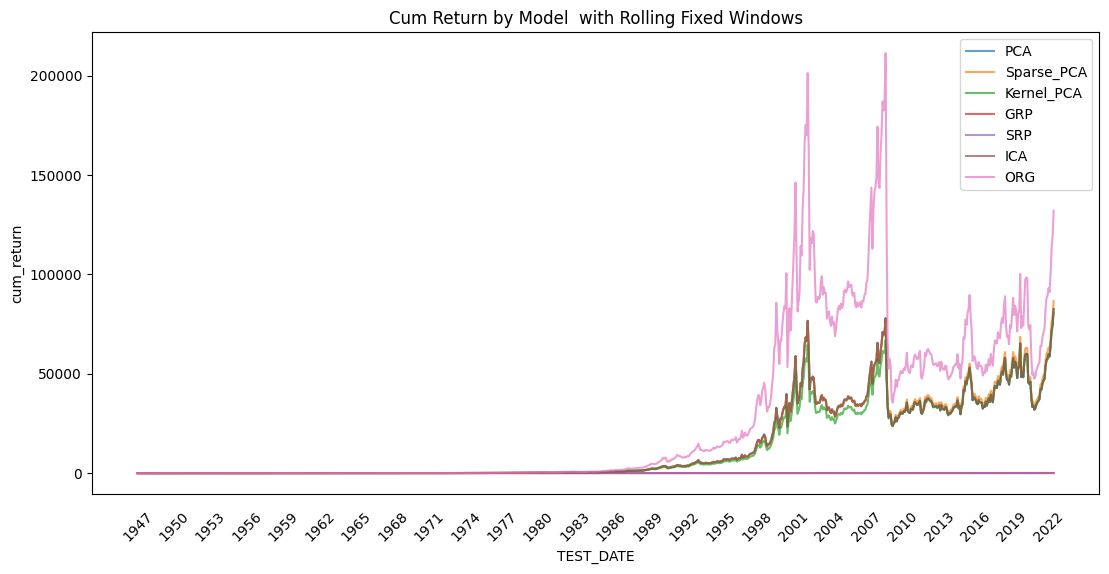

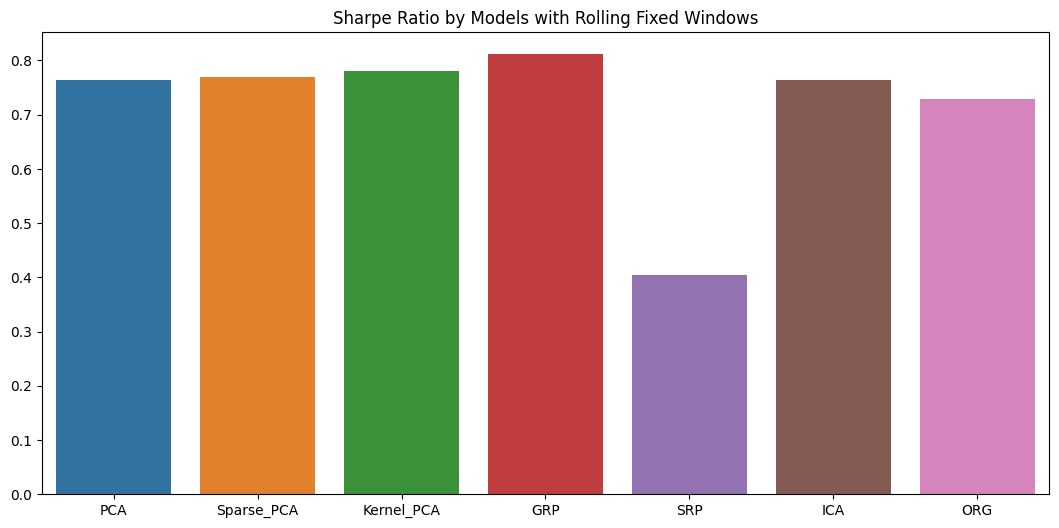

In [204]:
compare_sharpe_ratio(['PCA', 'Sparse_PCA', 'Kernel_PCA', 'GRP', 'SRP', 'ICA'],
                     [Fixed_PCA_Result, Fixed_Sparse_PCA_Result, Fixed_Kernel_PCA_Result,
                      Fixed_GRP_Result, Fixed_SRP_Result, Fixed_ICA_Result])